In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats
from matplotlib.collections import LineCollection

import plot_utils as pu
from digest import conds, get_digest_output, get_voltages, get_voltage_histograms
import isi_indexing as ii
from readout import load_results
import spatial

import conf.isi5_mouse as cfg
from demonstrator import demonstrator

In [2]:
labelling = {
    'nspikes': 'Response size',
    'pspike': 'Spike probability',
    'Activity': '$V_{static}$ (mV)',
    'Depression': '$V_{STD}$ (mV)',
    'Threshold': '$V_{TA}$ (mV)',
    'Synapses': '$V_{syn}$ (mV)',
    'Reset': '$V_{reset}$ (mV)',
    'v': 'Membrane potential v (mV)',
    'u': 'Undepressed potential u (mV)',
    'th_adapt': 'Threshold (mV)',
    'vsyn': '$v_{syn}$',
    'Vall': '$\\Sigma V$ (mV)'
}
depressive_measures = ('Depression', 'Threshold')
voltage_measures = depressive_measures + ('Synapses', 'Reset')
raw_measures = 'th_adapt', 'u', 'v', 'vsyn'
pu.colors.update({'Activity': 'cyan', 'Vall': 'k',
                  'th_adapt': pu.colors['Threshold'], 'u': pu.colors['Depression'], 'v': 'b', 'vsyn':'magenta'})
conds = ('std', 'msc', 'dev')
nonstandard = ('msc', 'dev')

In [3]:
isi, STD, TA, templ = 500, 0, 1, 'R'
net, ipair, istim = [demonstrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim, Bstim = cfg.pairings[ipair], cfg.pairings[ipair][istim], cfg.pairings[ipair][1-istim]
res = load_results(cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ), {'u': 'v'})
res['voltage_histograms'] = get_voltage_histograms(cfg.params, res)
res['processed_dynamics'] = get_voltages(cfg.params, res['raw_dynamics'])

In [4]:
quarters = [.25, .5, .75]

In [5]:
histograms = {cond: {
    'pspike': res['spikes'][ipair][stim][cond]['spike_hist'],
    **{measure: res['voltage_histograms'][measure][ipair][stim][cond] for measure in voltage_measures}
} for cond in conds}

In [6]:
raw_voltages = {cond: {
    **get_voltages(cfg.params, {k:v*volt for k,v in res['dynamics'][ipair][stim][cond].items()}),
    **{k:v*volt for k,v in res['dynamics'][ipair][stim][cond].items()},
} for cond in conds}
for v in raw_voltages.values():
    v['Vall'] = cfg.params['v_rest'] - cfg.params['v_threshold'] + v['Synapses'] + v['Reset'] - v['Depression'] - v['Threshold']
    assert np.allclose(v['Vall']/mV, (v['v'] - (cfg.params['v_threshold']+v['th_adapt']))/mV)

In [7]:
index_N, index_t = ii.get_onset_ordering(cfg, np.stack([h['pspike'] for h in histograms.values()]))
tmax = np.max(index_t)+1
time = np.arange(tmax) * cfg.params['dt']

In [8]:
episodes = {cond: res['pairs'][ipair][cond][stim] for cond in conds}
sequences = {cond: res['sequences'][episode] for cond, episode in episodes.items()}
trials = {cond: seq == cfg.stimuli[stim] for cond, seq in sequences.items()}
trials.update({f'{cond}-nontarget': seq != cfg.stimuli[stim] for cond, seq in sequences.items()})
trials.update({f'{cond}-B': seq == cfg.stimuli[cfg.pairings[ipair][1-istim]] for cond, seq in sequences.items()})

In [9]:
bspikes = {}
for cond in conds:
    bspikes[cond] = np.zeros((cfg.params['N'], len(sequences[cond]), res['raw_dynamics']['v'].shape[-1]), bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episodes[cond]][k] for k in ('pulsed_i', 'pulsed_t')])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        bspikes[cond][i, itrial, t] = True
    assert np.all(bspikes[cond].sum(2) == res['raw_spikes'][episodes[cond]]['pulsed_nspikes'].T)

In [10]:
netf = dd.io.load(cfg.netfile.format(net=net))
X, Y = netf['X']/cfg.params['r_dish'].item(), netf['Y']/cfg.params['r_dish'].item()
W = netf['W']

In [11]:
def scatter_values(ax, **kwargs):
    m = ax.scatter(X, Y, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    sns.despine(ax=ax, left=True, bottom=True)
    return m

In [13]:
D = spatial.get_distance_to_stim(cfg.stimuli[Bstim], W, netf['X']*meter, netf['Y']*meter, cfg.params)
DA = spatial.get_distance_to_stim(cfg.stimuli[stim], W, netf['X']*meter, netf['Y']*meter, cfg.params)

trying to illustrate the hypothesis for Zenas's Salon talk:

In [22]:
def lowpass(signal, bandlimit=.5, samplingrate=2):
    bandlimit_index = int(bandlimit * signal.size / samplingrate)
    fsig = np.fft.fft(signal)
    fsig[bandlimit_index+1 : -bandlimit_index] = 0
    return np.real(np.fft.ifft(fsig))

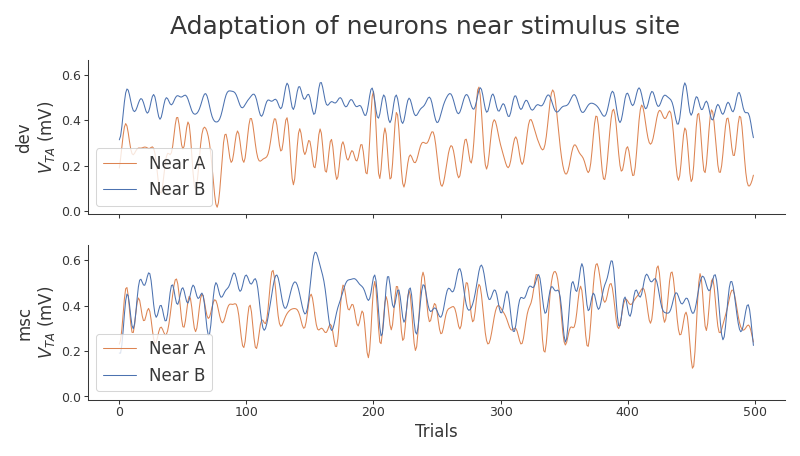

In [108]:
fig, axs = plt.subplots(2, figsize=(6,3), dpi=150, sharex=True, sharey=True)
d = 2
for ax, cond in zip(axs, ('dev', 'msc')):
    for i, (Dx, AB) in enumerate(((DA, 'A'), (D, 'B'))):
        v = res['raw_dynamics']['th_adapt'][Dx<d, episodes[cond], :, 0].mean(0)/mV
        ax.plot(lowpass(v, bandlimit=.25), label=f'Near {AB}', c=f'C{1-i}')
    ax.set_ylabel(f'{cond}\n$V_{{TA}}$ (mV)')
    ax.legend(loc='lower left')
axs[-1].set_xlabel('Trials')
fig.suptitle('Adaptation of neurons near stimulus site')
sns.despine()

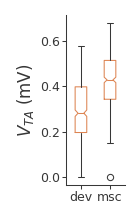

In [106]:
plt.figure(figsize=(.5,1.5), dpi=150)
plt.boxplot(
    [res['raw_dynamics']['th_adapt'][:, episodes[cond], :, 0].mean(0)/mV for cond in ('dev', 'msc')],
    notch=True, labels=('dev', 'msc'), boxprops={'color': 'C1'}, widths=.4)
plt.ylabel('$V_{TA}$ (mV)')
sns.despine()

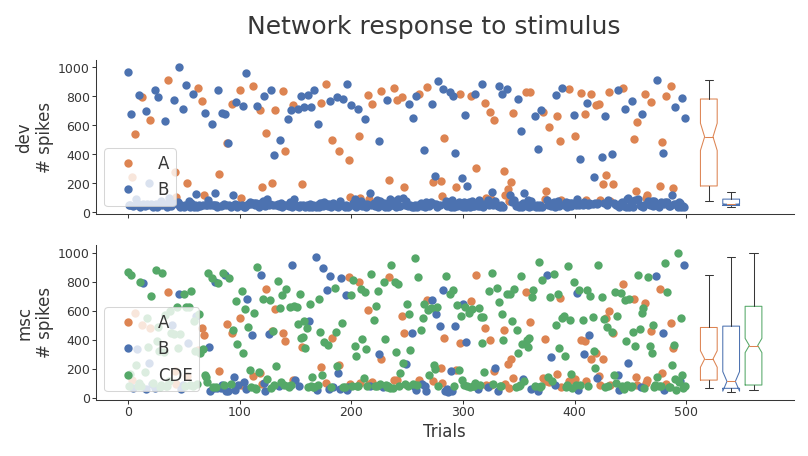

In [103]:
fig, axs = plt.subplots(2, figsize=(6,3), dpi=150, sharex=True, sharey=True)

# dev:
ax = axs[0]
n = res['raw_spikes'][episodes['dev']]['pulsed_nspikes'].sum(1)
t = np.arange(n.size)
for i, tr in enumerate((trials['dev'], ~trials['dev'])):
    ax.plot(t[tr], n[tr], '.', label='A' if i==0 else 'B', c=f'C{1-i}')
    ax.boxplot(n[tr], positions=[520 + 20*i], widths=[15], notch=True, manage_ticks=False, boxprops={'color': f'C{1-i}'}, showfliers=False)
ax.set_ylabel('dev\n# spikes')
ax.legend(loc='lower left')

# msc:
ax = axs[1]
n = res['raw_spikes'][episodes['msc']]['pulsed_nspikes'].sum(1)
t = np.arange(n.size)
for i, tr in enumerate((trials['msc'], trials['msc-B'], ~(trials['msc']|trials['msc-B']))):
    c = f'C{(1-i)}' if i<2 else f'C{i}'
    ax.plot(t[tr], n[tr], '.', label=('A','B','CDE')[i], c=c)
    ax.boxplot(n[tr], positions=[520 + 20*i], widths=[15], notch=True, manage_ticks=False, boxprops={'color': c}, showfliers=False)
ax.set_ylabel('msc\n# spikes')
ax.legend(loc='lower left')

axs[-1].set_xlabel('Trials')
fig.suptitle('Network response to stimulus')
sns.despine()

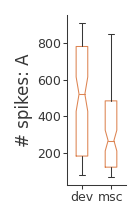

In [98]:
plt.figure(figsize=(.5,1.5), dpi=150)
plt.boxplot(
    [res['raw_spikes'][episodes[cond]]['pulsed_nspikes'][trials[cond]].sum(1) for cond in ('dev', 'msc')],
    notch=True, labels=('dev', 'msc'), boxprops={'color': 'C1'}, widths=.4)
plt.ylabel('# spikes: A')
sns.despine()

Note: From here on out, labelling of A,B refers to nominal deviant, nominal standard respectively, and bears no relation to the spatial location of the stimuli.

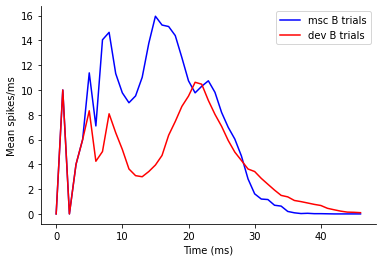

In [14]:
fig, ax = plt.subplots()
for cond in nonstandard:
    ax.plot(bspikes[cond][:, trials[f'{cond}-B'], :tmax].sum(0).mean(0), color=pu.colors[cond], label=f'{cond} B trials')
plt.legend()
plt.ylabel('Mean spikes/ms')
plt.xlabel('Time (ms)')
sns.despine()

In [15]:
context = {'msc': 'Control', 'dev': 'Oddball', 'std': 'Oddball', 'initial': 'initial'}

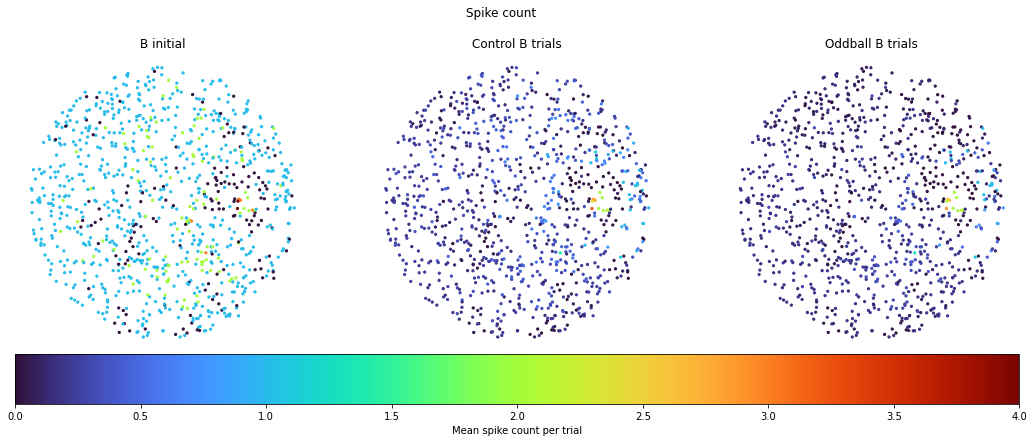

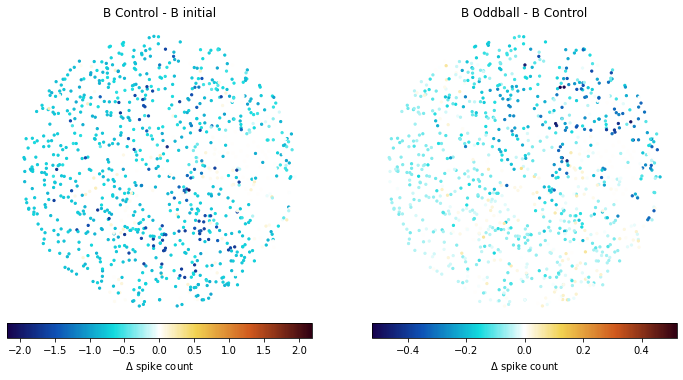

In [16]:
fig, axs = plt.subplots(1,3, figsize=(18,6.5))
fig2, axs2 = plt.subplots(1,2, figsize=(12,6.5))
vmax = max([bspikes[cond][:, trials[f'{cond}-B']].sum(2).mean(1).max() for cond in nonstandard])

C0 = bspikes['std' if sequences['dev'][0] == cfg.stimuli[stim] else 'dev'][:, 0].sum(1)
vmax = max(vmax, C0.max())
m = scatter_values(axs[0], c=C0, s=5, cmap='turbo', vmax=vmax)
axs[0].set_title(f'B initial')

for ax, ax2, cond, comparison in zip(axs[1:], axs2, nonstandard, ('initial', *nonstandard[:-1])):
    C = bspikes[cond][:, trials[f'{cond}-B']].sum(2).mean(1)
    scatter_values(ax, c=C, s=5, cmap='turbo', vmax=vmax)
    ax.set_title(f'{context[cond]} B trials')

    dC = C-C0
    dCmax = np.abs(dC).max()
    m2 = scatter_values(ax2, c=dC, s=5, cmap=pu.ccc_divergent, vmin=-dCmax, vmax=dCmax)
    fig2.colorbar(m2, ax=ax2, orientation='horizontal', pad=0, label='$\\Delta$ spike count')
    ax2.set_title(f'B {context[cond]} - B {context[comparison]}')

    C0=C
fig.colorbar(m, ax=axs, orientation='horizontal', pad=0, label='Mean spike count per trial')
fig.suptitle('Spike count')
for fig in (fig, fig2):
    sns.despine(fig, left=True, bottom=True)

- Initial/unadapted firing is highest, and diminished in most of the dish (except in the very nearby neighborhood) by the MSC protocol.
- Oddball reduces B/std in the entire dish, but particularly in the region near both A and B.

Text(0.5, 1.0, 'B Oddball - B Control')

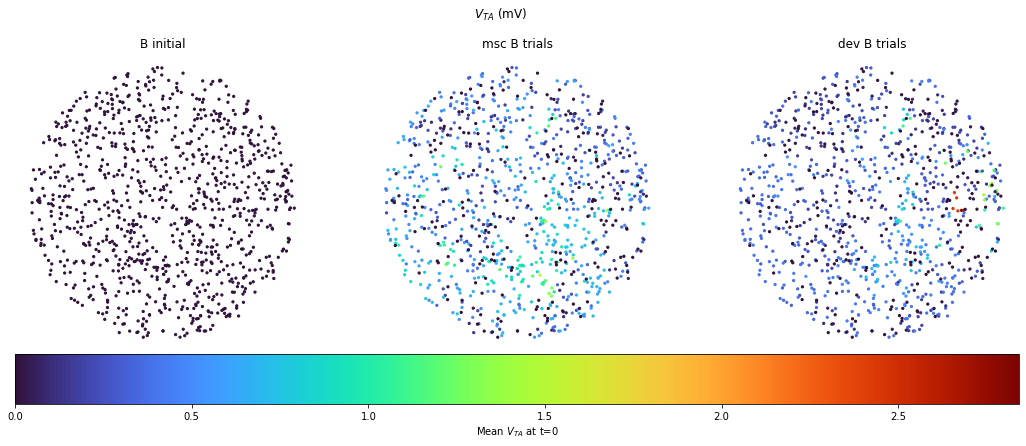

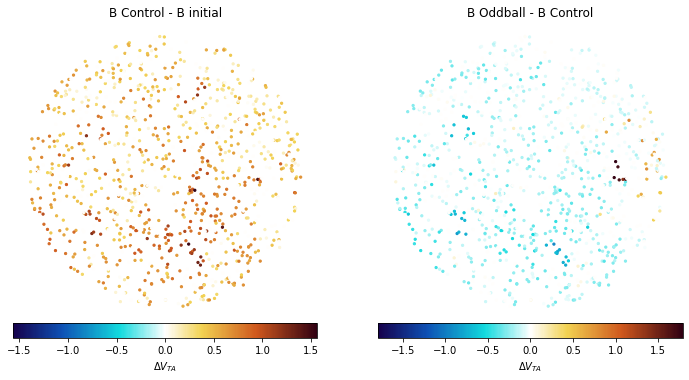

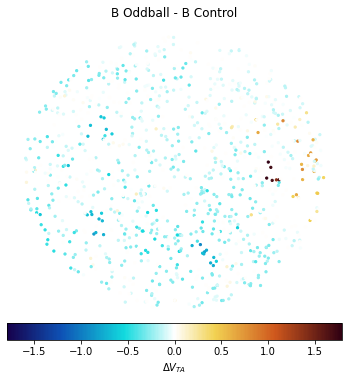

In [89]:
fig, axs = plt.subplots(1,3, figsize=(18,6.5))
fig2, axs2 = plt.subplots(1,2, figsize=(12,6.5))
vmax = max([res['processed_dynamics']['Threshold'][:, episodes[cond], trials[f'{cond}-B'], 0].mean(1).max() for cond in nonstandard])/mV

C0 = res['processed_dynamics']['Threshold'][:, episodes['std' if sequences['dev'][0] == cfg.stimuli[stim] else 'dev'], 0, 0]/mV
vmax = max(vmax, C0.max())
m = scatter_values(axs[0], c=C0, s=5, cmap='turbo', vmax=vmax)
axs[0].set_title(f'B initial')

for ax, ax2, cond, comparison in zip(axs[1:], axs2, nonstandard, ('initial', *nonstandard[:-1])):
    C = res['processed_dynamics']['Threshold'][:, episodes[cond], trials[f'{cond}-B'], 0].mean(1)/mV
    scatter_values(ax, c=C, s=5, cmap='turbo', vmax=vmax)
    ax.set_title(f'{cond} B trials')

    dTA = C-C0
    dCmax = np.abs(dTA).max()
    m2 = scatter_values(ax2, c=dTA, s=5, cmap=pu.ccc_divergent, vmin=-dCmax, vmax=dCmax)
    fig2.colorbar(m2, ax=ax2, orientation='horizontal', pad=0, label='$\\Delta V_{TA}$')
    ax2.set_title(f'B {context[cond]} - B {context[comparison]}')

    C0=C
fig.colorbar(m, ax=axs, orientation='horizontal', pad=0, label='Mean $V_{TA}$ at t=0')
fig.suptitle(labelling['Threshold'])
for fig in (fig, fig2):
    sns.despine(fig, left=True, bottom=True)

fig3, ax3 = plt.subplots(figsize=(6,6.5))
m2 = scatter_values(ax3, c=dTA, s=5, cmap=pu.ccc_divergent, vmin=-dCmax, vmax=dCmax)
fig3.colorbar(m2, ax=ax3, orientation='horizontal', pad=0, label='$\\Delta V_{TA}$')
ax3.set_title(f'B {context[cond]} - B {context[comparison]}')

- Thresholds are up throughout the dish in MSC
- Thresholds are lower in most of the dish in Oddball, except in the immediate B/std neighborhood, where thresholds are higher

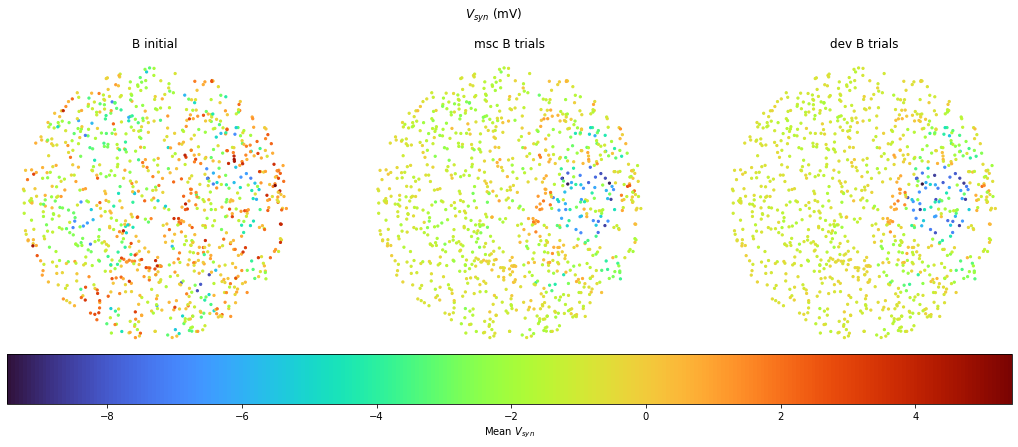

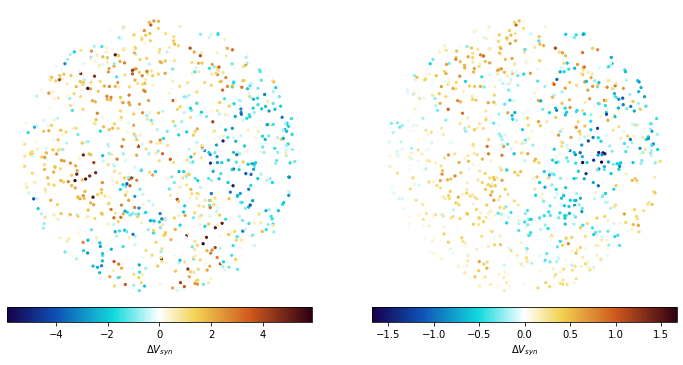

In [18]:
fig, axs = plt.subplots(1,3, figsize=(18,6.5))
fig2, axs2 = plt.subplots(1,2, figsize=(12,6.5))
vmax = max([res['processed_dynamics']['Synapses'][:, episodes[cond], trials[f'{cond}-B']].mean((1,2)).max() for cond in nonstandard])/mV

C0 = res['processed_dynamics']['Synapses'][:, episodes['std' if sequences['dev'][0] == cfg.stimuli[stim] else 'dev'], 0].mean(1)/mV
vmax = max(vmax, C0.max())
m = scatter_values(axs[0], c=C0, s=5, cmap='turbo', vmax=vmax)
axs[0].set_title(f'B initial')

for ax, ax2, cond in zip(axs[1:], axs2, nonstandard):
    C = res['processed_dynamics']['Synapses'][:, episodes[cond], trials[f'{cond}-B']].mean((1,2))/mV
    scatter_values(ax, c=C, s=5, cmap='turbo', vmax=vmax)
    ax.set_title(f'{cond} B trials')

    dSyn = C-C0
    dCmax = np.abs(dSyn).max()
    m2 = scatter_values(ax2, c=dSyn, s=5, cmap=pu.ccc_divergent, vmin=-dCmax, vmax=dCmax)
    fig2.colorbar(m2, ax=ax2, orientation='horizontal', pad=0, label='$\\Delta V_{syn}$')

    C0=C
fig.colorbar(m, ax=axs, orientation='horizontal', pad=0, label='Mean $V_{syn}$')
fig.suptitle(labelling['Synapses'])
for fig in (fig, fig2):
    sns.despine(fig, left=True, bottom=True)

- Synaptic currents (summed over B trial duration) are notably low in both MSC and Oddball, particularly in the immediate neighborhood.
    - Note that B includes 4 inhibitory neurons.
- Synaptic currents are lower in Oddball than MSC in a wide/diffuse neighborhood around B

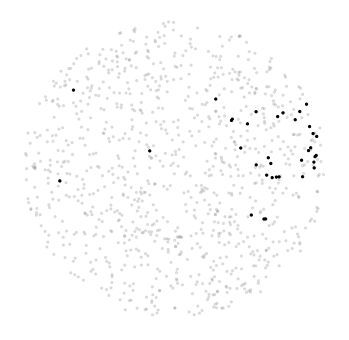

In [90]:
fig, ax = plt.subplots(figsize=(6,6))
mask = (dTA>0) & (dSyn<0)
scatter_values(ax, s=np.where(mask, np.nan, 5), color='grey', alpha=.2)
scatter_values(ax, s=np.where(mask, 5, np.nan), color='k')

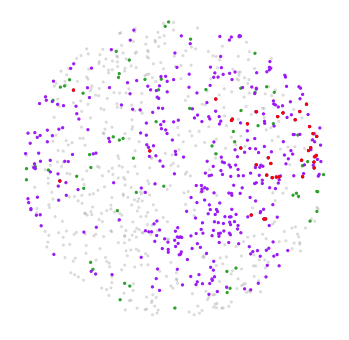

In [20]:
fig, ax = plt.subplots(figsize=(6,6))
scatter_values(ax, s=np.where((dTA<=0) & (dSyn>=0), 5, np.nan), color='grey', alpha=.2)
scatter_values(ax, s=np.where((dTA>0), 5, np.nan), color=pu.colors['Threshold'], alpha=1)
scatter_values(ax, s=np.where((dSyn<0), 5, np.nan), color=pu.colors['Depression'], alpha=1)
scatter_values(ax, s=np.where((dTA>0) & (dSyn<0), 5, np.nan), color='r')

598

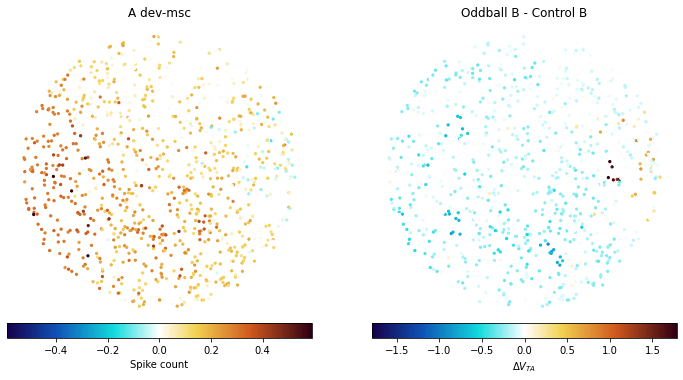

In [97]:
fig, axs = plt.subplots(1,2, figsize=(12,6.5))

dXA = bspikes['dev'][:, sequences['dev']==cfg.stimuli[stim]].sum(2).mean(1)-bspikes['msc'][:, sequences['msc']==cfg.stimuli[stim]].sum(2).mean(1)
dXAmax = np.abs(dXA).max()
m = scatter_values(axs[0], c=dXA, s=5, cmap=pu.ccc_divergent, vmin=-dXAmax, vmax=dXAmax)
plt.colorbar(m, ax=axs[0], orientation='horizontal', pad=0, label='Spike count')
axs[0].set_title(f'A dev-msc')

dCmax = np.abs(dTA).max()
m = scatter_values(axs[1], c=dTA, s=5, cmap=pu.ccc_divergent, vmin=-dCmax, vmax=dCmax)
plt.colorbar(m, ax=axs[1], orientation='horizontal', pad=0, label='$\\Delta V_{TA}$')
axs[1].set_title('Oddball B - Control B')
sns.despine(left=True, bottom=True)

np.sum((C>0) & (dTA<0))

LinregressResult(slope=-0.15673574450528918, intercept=0.13516274043982576, rvalue=-0.3152661851235383, pvalue=1.6327450247095235e-24, stderr=0.014934583111432009, intercept_stderr=0.004010175034649174)

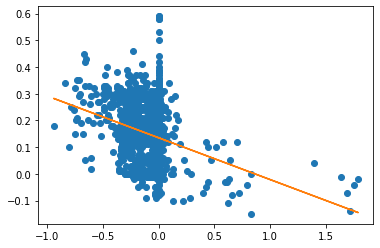

In [100]:
plt.scatter(dTA, dXA)
regression = stats.linregress(dTA, dXA)
plt.plot(dTA, regression.intercept  + regression.slope*dTA, 'C1')
regression

In [22]:
Xstd = bspikes['dev'][:, sequences['dev']==cfg.stimuli[Bstim]]
Xdev = bspikes['dev'][:, sequences['dev']==cfg.stimuli[stim]]
Xmsc = bspikes['msc'][:, sequences['msc']==cfg.stimuli[Bstim]]

In [23]:
# temporary measure
# settled_std_trials = sequences['dev']==cfg.stimuli[Bstim]
# settled_std_trials[np.flatnonzero(sequences['dev']==cfg.stimuli[stim]) + 1] = False
# Xstd = bspikes['dev'][:, settled_std_trials]

In [24]:
latency = int(cfg.params['refractory_exc'] / cfg.params['dt'] + .5)
Xe = Xstd[:cfg.params['N_exc']]
Wb = ~np.isnan(W)
We = Wb[:cfg.params['N_exc']]

In [25]:
evoked = np.zeros((800, 1000))
for pre, trial, t in zip(*np.nonzero(Xe)):
    tmax = min(t+latency, Xstd.shape[-1]-1)
    for post in np.flatnonzero(We[pre]):
        evoked[pre, post] += np.sum(Xstd[post, trial, t+1:tmax+1])>0

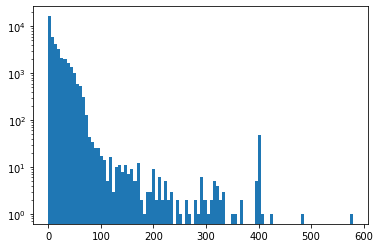

In [26]:
plt.hist(evoked[We], bins=100, log=True);

In [27]:
reliability = 2 * evoked / (Xe.sum((1,2))[:, None] + Xstd.sum((1,2))[None, :])
reliability[np.isnan(W[:cfg.params['N_exc']])] = np.nan

WARNING    /tmp/ipykernel_64411/746517008.py:1: RuntimeWarning: invalid value encountered in true_divide
  reliability = 2 * evoked / (Xe.sum((1,2))[:, None] + Xstd.sum((1,2))[None, :])
 [py.warnings]


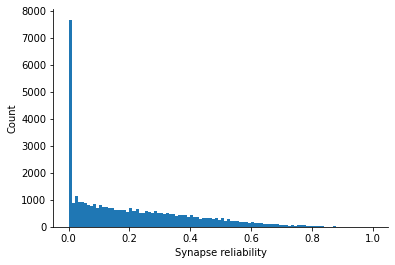

In [28]:
plt.hist(reliability[We], bins=100)
plt.xlabel('Synapse reliability')
plt.ylabel('Count')
sns.despine()

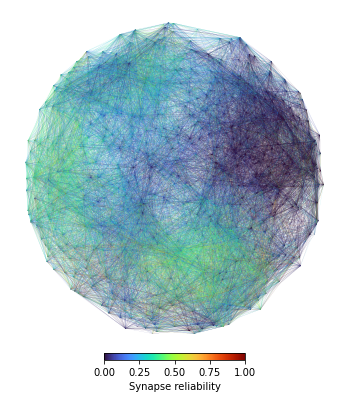

In [29]:
fig, ax = plt.subplots(figsize=(6,6.5))
segments = np.zeros((We.sum(), 2, 2))
segments[:, 0] = np.transpose([C[np.nonzero(We)[0]] for C in (X,Y)])
segments[:, 1] = np.transpose([C[np.nonzero(We)[1]] for C in (X,Y)])

lines = LineCollection(segments, linewidths=.05)
lines.set_array(reliability[We])
lines.set_clim(0,1)
lines.set_cmap('turbo')
ax.add_collection(lines)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)

plt.colorbar(lines, ax=ax, orientation='horizontal', pad=0, label='Synapse reliability', fraction=.02)
sns.despine(left=True, bottom=True)

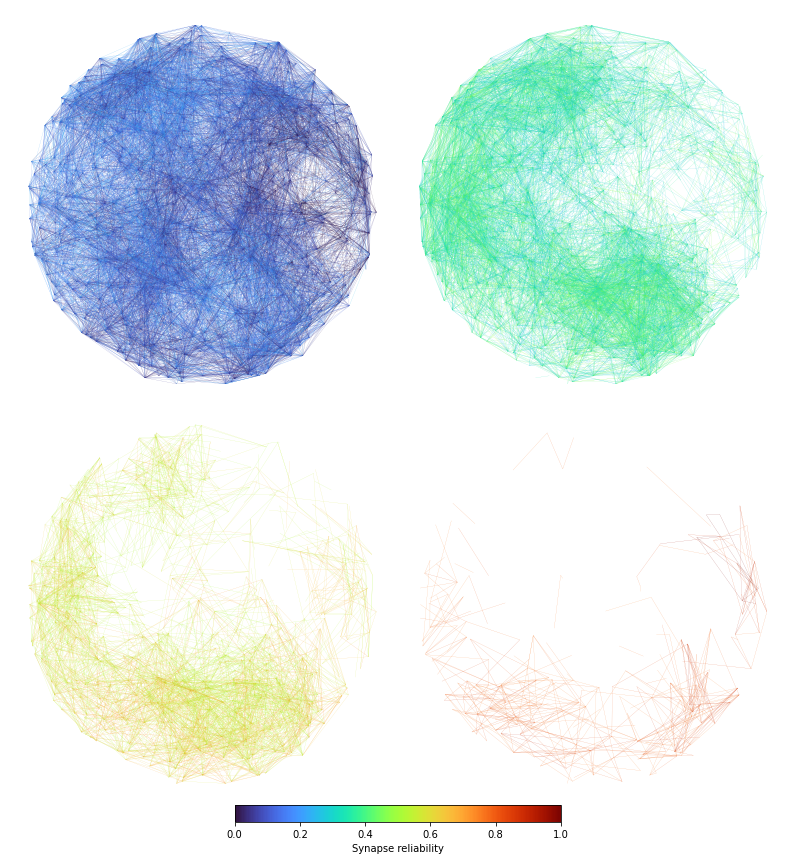

In [30]:
step = .25
fig, axs = plt.subplots(2, 2, figsize=(14,15), gridspec_kw={'wspace': 0, 'hspace': 0})
for ax, lo in zip(axs.flatten(), np.arange(0, 1, step)):
    segments = np.zeros((We.sum(), 2, 2))
    segments[:, 0] = np.transpose([C[np.nonzero(We)[0]] for C in (X,Y)])
    segments[:, 1] = np.transpose([C[np.nonzero(We)[1]] for C in (X,Y)])

    mask = (reliability[We] > lo) & (reliability[We] <= lo+step)
    lines = LineCollection(segments[mask], linewidths=.1)
    lines.set_array(reliability[We][mask])
    lines.set_clim(0,1)
    lines.set_cmap('turbo')
    ax.add_collection(lines)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)

plt.colorbar(lines, ax=axs, orientation='horizontal', pad=0, label='Synapse reliability', fraction=.02)
sns.despine(left=True, bottom=True)

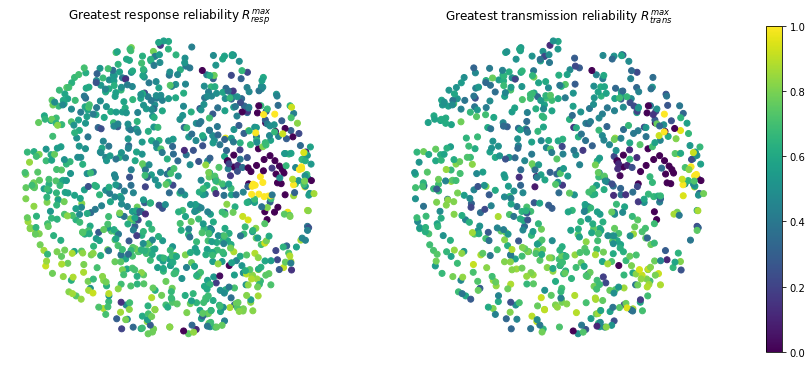

In [31]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
rel_response = np.nanmax(reliability, 0)
rel_response[netf['stimulated_neurons'][cfg.stimuli[Bstim]]] = 1
rel_transmit = np.concatenate((np.nanmax(reliability, 1), np.full(cfg.params['N_inh'], np.nan)))
m = scatter_values(axs[0], c=rel_response, vmin=0, vmax=np.nanmax(reliability))
axs[0].set_title('Greatest response reliability $R_{resp}^{max}$')
scatter_values(axs[1], c=rel_transmit, vmin=0, vmax=np.nanmax(reliability))
axs[1].set_title('Greatest transmission reliability $R_{trans}^{max}$')
plt.colorbar(m, ax=axs);

In [112]:
def get_delta_R(Rsyn):
    R_resp = np.nanmax(Rsyn, 0)
    R_resp[netf['stimulated_neurons'][cfg.stimuli[Bstim]]] = 1
    R_trans = np.concatenate((np.nanmax(Rsyn, 1), np.full(cfg.params['N_inh'], np.nan)))
    return R_trans - R_resp

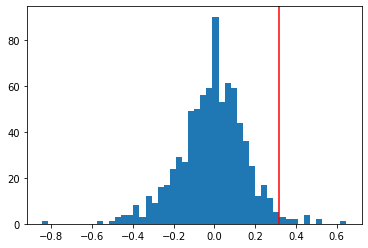

In [33]:
diff_rel = get_delta_R(reliability)
plt.hist(diff_rel, bins=50)
twoz = np.nanmean(diff_rel) + 2*np.nanstd(diff_rel)
plt.axvline(twoz, color='r')

In [34]:
gatekeepers = np.flatnonzero(diff_rel > twoz)
others = np.arange(cfg.params['N_exc'])
others[gatekeepers] = -1
others = others[others >= 0]

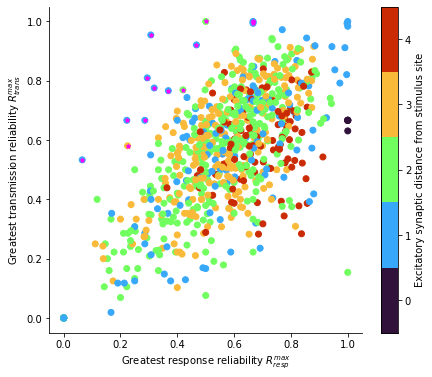

In [35]:
plt.figure(figsize=(7,6))
m = plt.scatter(rel_response, rel_transmit, c=D, cmap='turbo', vmax=D.max()+.5)
plt.scatter(rel_response[gatekeepers], rel_transmit[gatekeepers], c='magenta', s=20, marker='*')
plt.xlabel('Greatest response reliability $R_{resp}^{max}$')
plt.ylabel('Greatest transmission reliability $R_{trans}^{max}$')
plt.colorbar(m, values=range(D.max()+1), label='Excitatory synaptic distance from stimulus site')
sns.despine()

Text(0.5, 1.0, 'Gatekeepers ($\\Delta R > \\mu + 2 \\sigma$)')

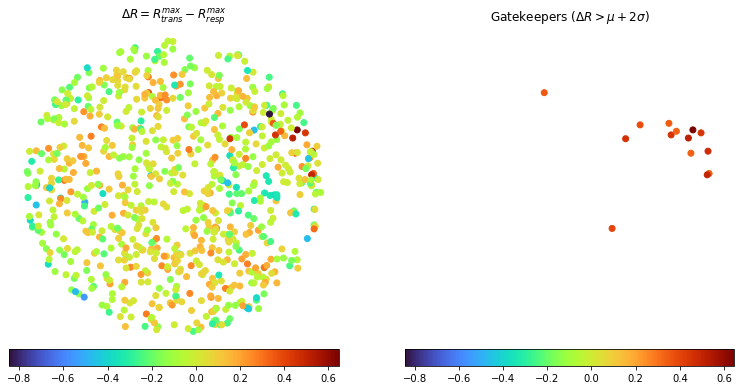

In [36]:
fig, axs = plt.subplots(1,2,figsize=(13,7))
m = scatter_values(axs[0], c=diff_rel, cmap='turbo')
plt.colorbar(m, ax=axs[0], orientation='horizontal', pad=0)
axs[0].set_title('$\\Delta R = R_{trans}^{max} - R_{resp}^{max}$')
m = scatter_values(axs[1], c=np.where(diff_rel > twoz, diff_rel, np.nan), cmap='turbo', vmin=np.nanmin(diff_rel))
plt.colorbar(m, ax=axs[1], orientation='horizontal', pad=0)
axs[1].set_title('Gatekeepers ($\\Delta R > \\mu + 2 \\sigma$)')

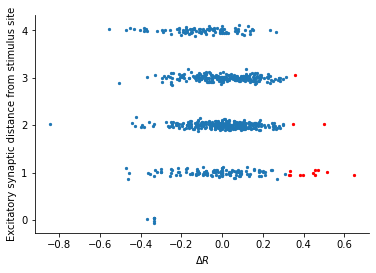

In [37]:
plt.scatter(diff_rel[others], D[others]+np.random.normal(scale=.05, size=others.size), s=5)
plt.scatter(diff_rel[gatekeepers], D[gatekeepers]+np.random.normal(scale=.05, size=gatekeepers.size), s=5, c='r')
plt.xlabel('$\\Delta R$')
plt.ylabel('Excitatory synaptic distance from stimulus site')
sns.despine()

In [38]:
def bootstrap_sameD(x, n=10000, ci=.95, stat=np.nanmean, alternative='two-sided', D=D):
    Didx = [np.flatnonzero(D==i) for i in range(D.max()+1)]
    Dcount = [np.isin(gatekeepers, idx).sum() for idx in Didx]
    rng = np.random.default_rng()
    bstat = np.empty(n)
    for i in range(n):
        idx = np.concatenate([rng.choice(idx, count, True) for idx, count in zip(Didx, Dcount)])
        bstat[i] = stat(x[idx])
    
    gstat = stat(x[gatekeepers])
    if alternative == 'two-sided':
        bmean = np.nanmean(bstat)
        p = np.sum(np.abs(gstat - bmean) < np.abs(bstat - bmean)) / bstat.size
    elif alternative=='greater':
        p = np.sum(gstat > bstat) / bstat.size
    elif alternative=='less':
        p = np.sum(gstat < bstat) / bstat.size
    
    return bstat, p, stats.norm.interval(ci, loc=np.nanmean(bstat), scale=np.nanstd(bstat))

In [39]:
def test_extreme(x, title, alternative='two-sided', D=D):
    if x.size == cfg.params['N_exc']:
        x = np.concatenate((x, np.full(cfg.params['N_inh'], np.nan)))
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle(f'{title} : testing {alternative}')
    axs[0].plot(diff_rel[others], x[others], 'o')
    axs[0].plot(diff_rel[gatekeepers], x[gatekeepers], 'ro')
    axs[0].boxplot(x[~np.isnan(x)], notch=True, manage_ticks=False)
    axs[0].set_ylabel(title)
    axs[0].set_xlabel('$\\Delta R$')
    ttest = stats.ttest_ind(x[others], x[gatekeepers], equal_var=False, permutations=10000, alternative=alternative)
    axs[0].set_title(f't={ttest.statistic:.2f}, p={ttest.pvalue:.4f}')

    means, p, ci = bootstrap_sameD(x, alternative=alternative, D=D)
    axs[1].hist(means, 100)
    axs[1].axvline(np.mean(x[gatekeepers]), c='r')
    axs[1].axvspan(*ci, color='g', alpha=.2)
    axs[1].set_ylabel('Count')
    axs[1].set_xlabel(f'Boostrapped average of {title}')
    axs[1].set_title(f'bootstrap p={p}')
    
    sns.despine()

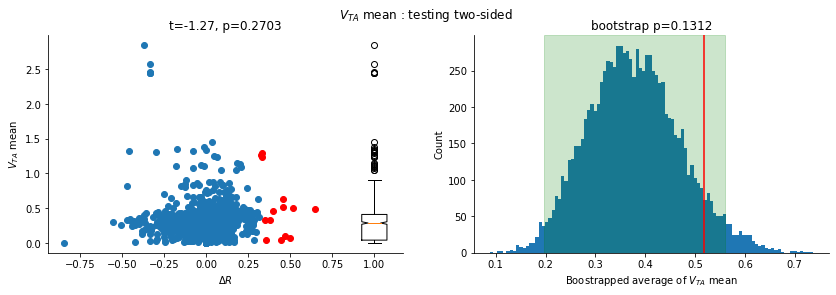

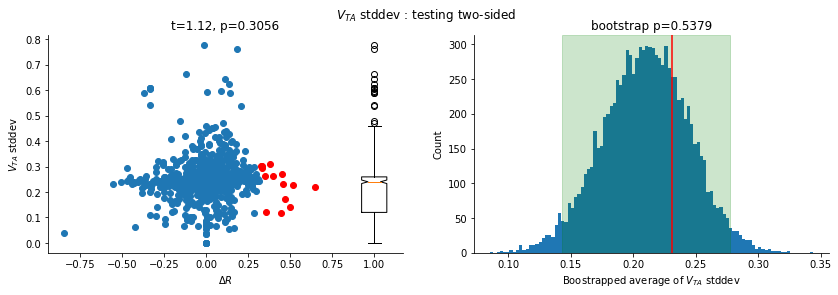

In [40]:
# v = res['processed_dynamics']['Threshold'][:, episodes['dev'], settled_std_trials, 0]/mV
v = res['processed_dynamics']['Threshold'][:, episodes['dev'], trials[f'dev-B'], 0]/mV
test_extreme(v.mean(1), '$V_{TA}$ mean')
test_extreme(v.std(1), '$V_{TA}$ stddev')

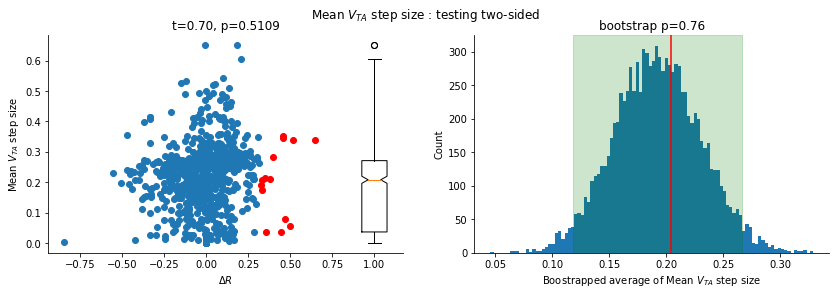

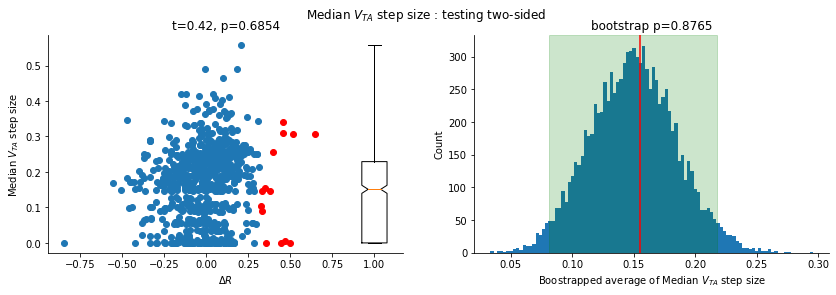

In [41]:
test_extreme(np.abs(np.diff(v, axis=1)).mean(1), 'Mean $V_{TA}$ step size')
test_extreme(np.median(np.abs(np.diff(v, axis=1)), 1), 'Median $V_{TA}$ step size')

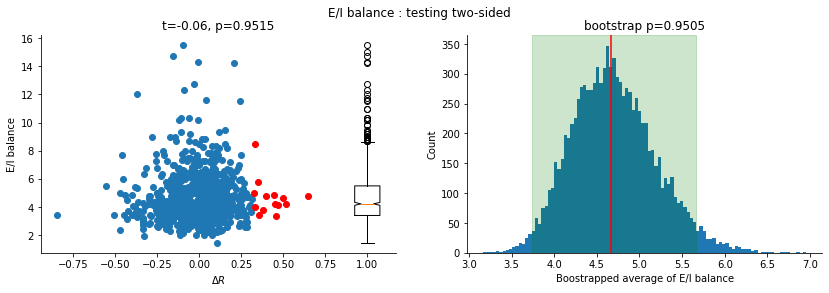

In [42]:
Wb = W>0
test_extreme(Wb[:cfg.params['N_exc']].sum(0) / Wb[cfg.params['N_exc']:].sum(0), 'E/I balance')

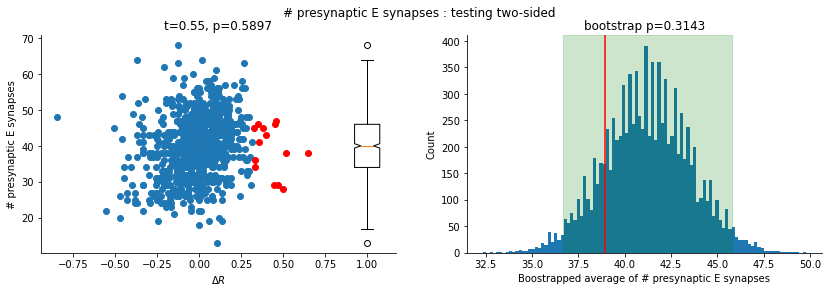

In [43]:
test_extreme(Wb[:cfg.params['N_exc']].sum(0), '# presynaptic E synapses')

### GK response reliability is low

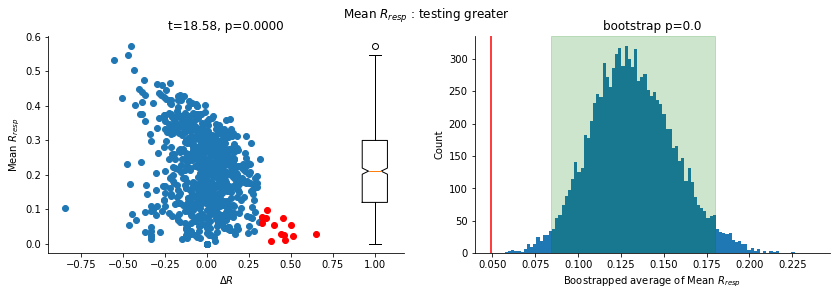

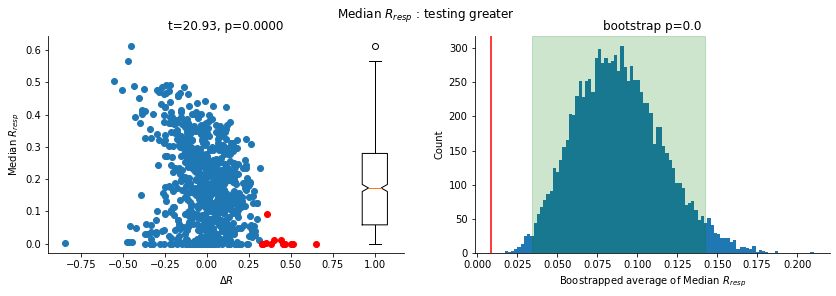

In [44]:
test_extreme(np.nanmean(reliability, 0), 'Mean $R_{resp}$', 'greater')
test_extreme(np.nanmedian(reliability, 0), 'Median $R_{resp}$', 'greater')

### GK transmission reliability is also low, but only just

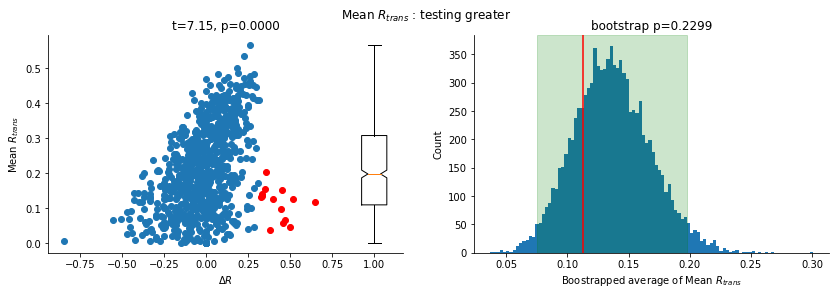

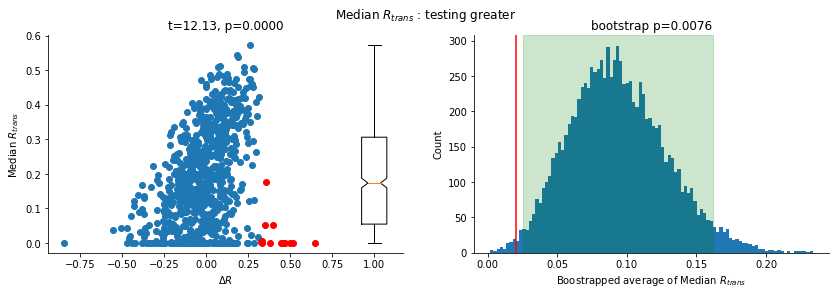

In [45]:
test_extreme(np.nanmean(reliability, 1), 'Mean $R_{trans}$', 'greater')
test_extreme(np.nanmedian(reliability, 1), 'Median $R_{trans}$', 'greater')

### GK input (total spikes/trial) is less variable

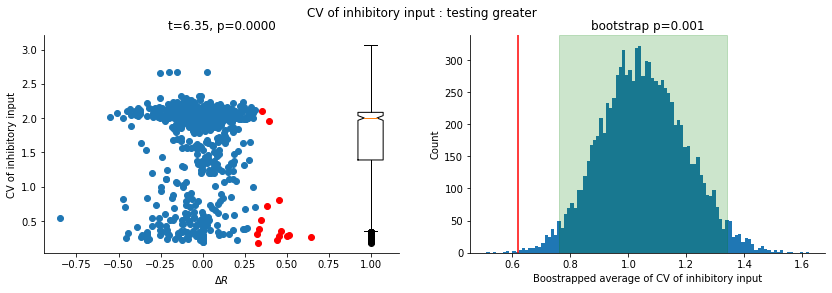

In [46]:
wi = Wb.copy()
wi[:cfg.params['N_exc']] = 0
inh_inputs = np.einsum('eo,et->ot', wi, Xstd.sum(2))
test_extreme(inh_inputs.std(1) / inh_inputs.mean(1), 'CV of inhibitory input', alternative='greater')

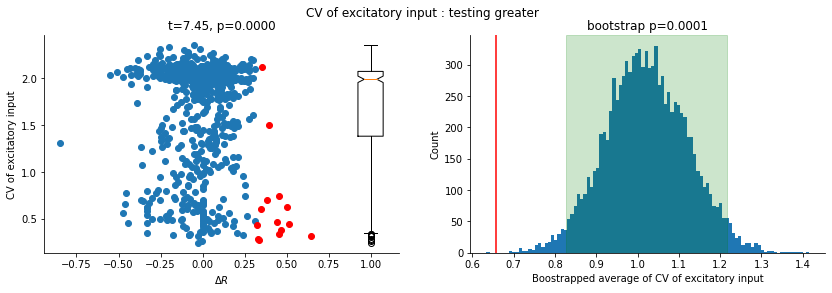

In [47]:
we = Wb.copy()
we[cfg.params['N_exc']:] = 0
exc_inputs = np.einsum('eo,et->ot', we, Xstd.sum(2))
test_extreme(exc_inputs.std(1) / exc_inputs.mean(1), 'CV of excitatory input', alternative='greater')

WARNING    /tmp/ipykernel_64411/4101291556.py:4: RuntimeWarning: invalid value encountered in true_divide
  cv = exc_inputs.std(1) / exc_inputs.mean(1)
 [py.warnings]


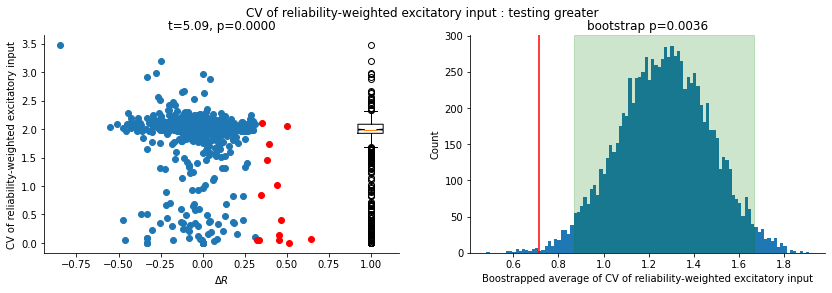

In [48]:
we = np.concatenate((reliability.copy(), np.zeros((cfg.params['N_inh'], cfg.params['N']))))
we[np.isnan(we)] = 0
exc_inputs = np.einsum('eo,et->ot', we, Xstd.sum(2))
cv = exc_inputs.std(1) / exc_inputs.mean(1)
cv[np.isnan(cv)] = 0
test_extreme(cv, 'CV of reliability-weighted excitatory input', alternative='greater')

### ... but GK output is more variable.

WARNING    /tmp/ipykernel_64411/4222154226.py:2: RuntimeWarning: invalid value encountered in true_divide
  act_cv = Xsum.std(1) / Xsum.mean(1)
 [py.warnings]


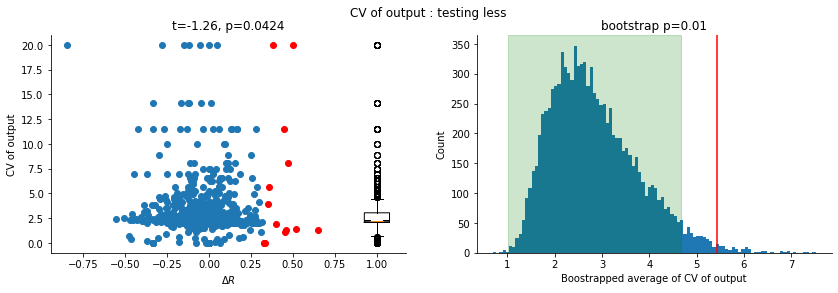

In [49]:
Xsum = Xstd.sum(2)
act_cv = Xsum.std(1) / Xsum.mean(1)
act_cv[np.isnan(act_cv)] = 0
test_extreme(act_cv, 'CV of output', 'less')

### No difference in response to B

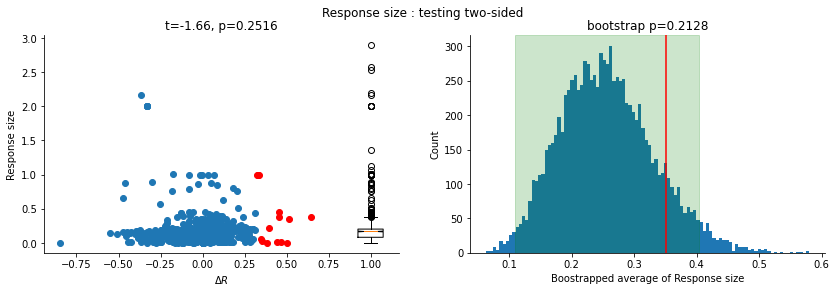

In [50]:
test_extreme(Xstd.sum(2).mean(1), 'Response size')

### GK responds less to deviant

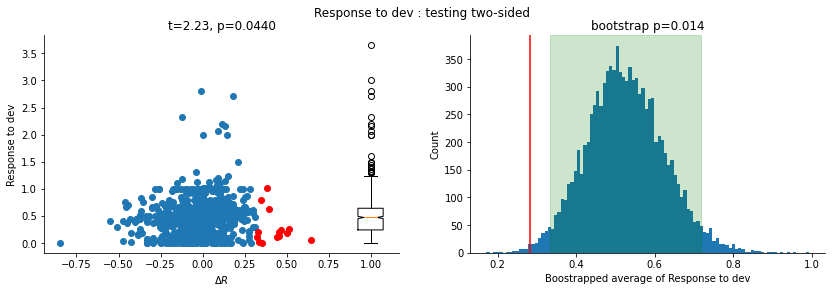

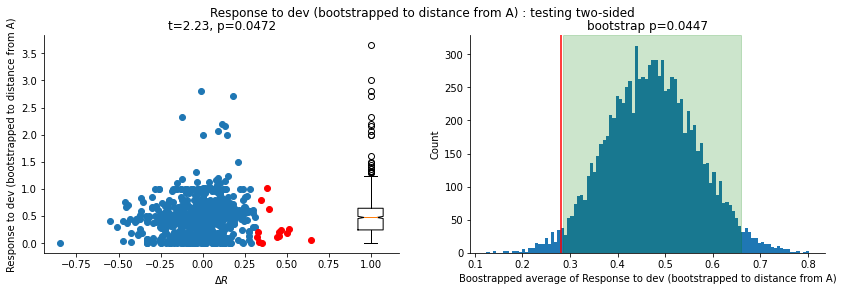

In [51]:
test_extreme(Xdev.sum(2).mean(1), 'Response to dev')
test_extreme(Xdev.sum(2).mean(1), 'Response to dev (bootstrapped to distance from A)', D=DA)

### GK is closer to spiking in silent trials

(MannwhitneyuResult(statistic=126500222.0, pvalue=0.0),
 -6.08904406 * mvolt,
 -2.35970163 * mvolt)

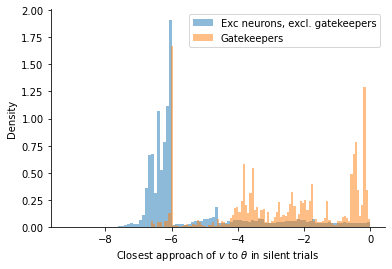

In [52]:
idx = (slice(None), episodes['dev'], trials[f'dev-B'], slice(None))
dv = (res['raw_dynamics']['v'][idx] - cfg.params['v_threshold']/volt - res['raw_dynamics']['th_adapt'][idx])*volt/mV
silent = Xstd.sum(2)==0

all_silent_dv = dv[others][silent[others]].max(1)
gk_silent_dv = dv[gatekeepers][silent[gatekeepers]].max(1)
plt.hist(all_silent_dv, 100, density=True, alpha=.5, label='Exc neurons, excl. gatekeepers')
plt.hist(gk_silent_dv, 100, density=True, alpha=.5, label='Gatekeepers')
plt.xlabel('Closest approach of $v$ to $\\theta$ in silent trials')
plt.ylabel('Density')
plt.legend()
sns.despine()

stats.mannwhitneyu(all_silent_dv, gk_silent_dv, alternative='less'), np.median(all_silent_dv)*mV, np.median(gk_silent_dv)*mV

{'pvalue': 0.0092}

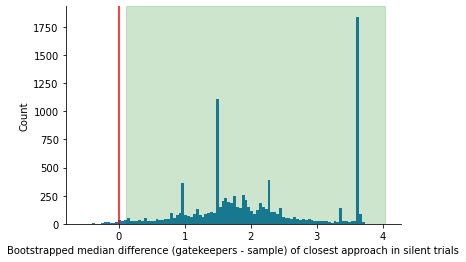

In [53]:
median_gk_dv = np.median(gk_silent_dv)
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=lambda idx: median_gk_dv - np.median(dv[idx][silent[idx]].max(1)), alternative='greater')
plt.hist(means, 100)
plt.axvline(0, c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped median difference (gatekeepers - sample) of closest approach in silent trials')
sns.despine()
{'pvalue': p}

### No difference in dV at spike times (no evidence of hair-trigger membrane voltage)

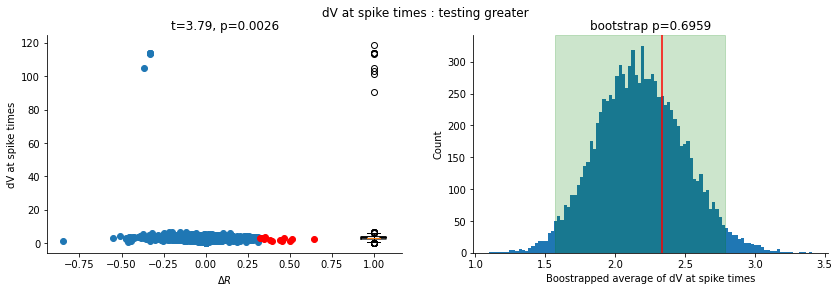

In [163]:
dVspike = np.zeros(cfg.params['N'])
neuron_idx = np.nonzero(Xstd)[0]
assert Xstd[:, :, 0].sum() == 0  # or mask out spikes at t=0
np.add.at(dVspike, neuron_idx, res['dynamics'][ipair][Bstim]['std']['v'][Xstd])
np.add.at(dVspike, neuron_idx, -res['dynamics'][ipair][Bstim]['std']['v'][np.roll(Xstd, -1, axis=2)])
i, ni = np.unique(neuron_idx, return_counts=True)
dVspike[i] /= ni
test_extreme(dVspike*volt/mV, 'dV at spike times', 'greater')

### No difference in thresholds at t=0

(MannwhitneyuResult(statistic=757881762.0, pvalue=2.060320685722529e-71),
 261.33167805 * uvolt,
 0.40177658 * mvolt)

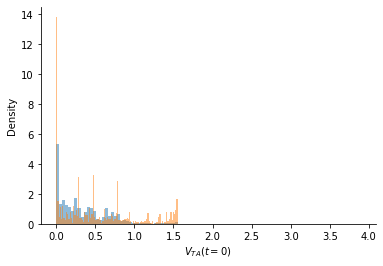

In [54]:
# th = res['raw_dynamics']['th_adapt'][:, episodes['dev'], settled_std_trials, 0]*volt/mV
th = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev-B'], 0]*volt/mV

plt.hist(th[others].flatten(), 100, density=True, alpha=.5, label='Excitatory neurons, excl. gatekeepers')
plt.hist(th[gatekeepers].flatten(), 100, density=True, alpha=.5, label='Gatekeepers')
plt.xlabel('$V_{TA}(t=0)$')
plt.ylabel('Density')
sns.despine()

stats.mannwhitneyu(th[others].flatten(), th[gatekeepers].flatten(), alternative='two-sided'), np.median(th[others])*mV, np.median(th[gatekeepers])*mV

{'pvalue': 0.1584}

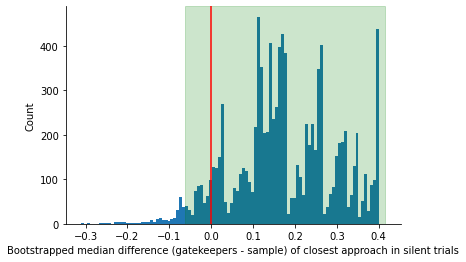

In [55]:
median_gk_th = np.median(th[gatekeepers])
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=lambda idx: median_gk_th - np.median(th[idx]), alternative='two-sided')
plt.hist(means, 100)
plt.axvline(0, c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped median difference (gatekeepers - sample) of closest approach in silent trials')
sns.despine()
{'pvalue': p}

### No difference in thresholds of silent trials (t=0)

(MannwhitneyuResult(statistic=523439312.0, pvalue=1.5498214122556967e-20),
 266.03012731 * uvolt,
 225.76125687 * uvolt)

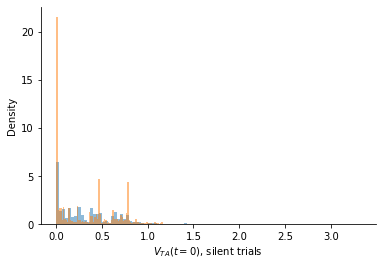

In [56]:
plt.hist(th[others][silent[others]].flatten(), 100, density=True, alpha=.5, label='Excitatory neurons, excl. gatekeepers')
plt.hist(th[gatekeepers][silent[gatekeepers]].flatten(), 100, density=True, alpha=.5, label='Gatekeepers')
plt.xlabel('$V_{TA}(t=0)$, silent trials')
plt.ylabel('Density')
sns.despine()

(stats.mannwhitneyu(th[others][silent[others]].flatten(), th[gatekeepers][silent[gatekeepers]].flatten(), alternative='two-sided'),
 np.median(th[others][silent[others]])*mV, np.median(th[gatekeepers][silent[gatekeepers]])*mV)

{'pvalue': 0.8798}

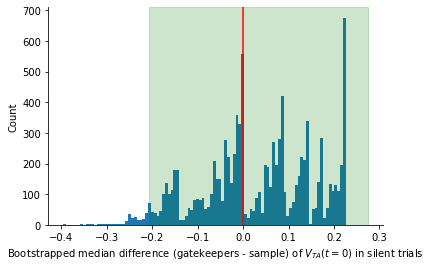

In [170]:
median_gk_th = np.median(th[gatekeepers][silent[gatekeepers]])
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=lambda idx: median_gk_th - np.median(th[idx][silent[idx]]), alternative='two-sided')
plt.hist(means, 100)
plt.axvline(0, c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped median difference (gatekeepers - sample) of $V_{TA}(t=0)$ in silent trials')
sns.despine()
{'pvalue': p}

### ... nor in spiking trials

(MannwhitneyuResult(statistic=22398158.0, pvalue=0.0),
 232.3286819 * uvolt,
 0.93916098 * mvolt)

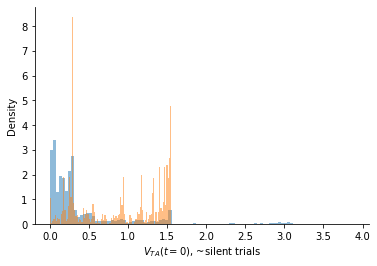

In [168]:
plt.hist(th[others][~silent[others]].flatten(), 100, density=True, alpha=.5, label='Excitatory neurons, excl. gatekeepers')
plt.hist(th[gatekeepers][~silent[gatekeepers]].flatten(), 100, density=True, alpha=.5, label='Gatekeepers')
plt.xlabel('$V_{TA}(t=0)$, ~silent trials')
plt.ylabel('Density')
sns.despine()

(stats.mannwhitneyu(th[others][~silent[others]].flatten(), th[gatekeepers][~silent[gatekeepers]].flatten(), alternative='two-sided'),
 np.median(th[others][~silent[others]])*mV, np.median(th[gatekeepers][~silent[gatekeepers]])*mV)

{'pvalue': 0.0558}

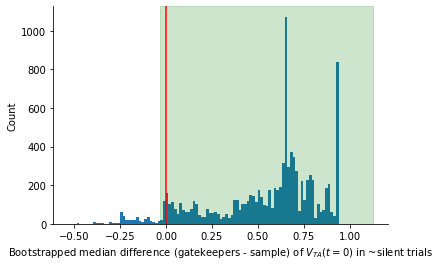

In [171]:
median_gk_th = np.median(th[gatekeepers][~silent[gatekeepers]])
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=lambda idx: median_gk_th - np.median(th[idx][~silent[idx]]), alternative='two-sided')
plt.hist(means, 100)
plt.axvline(0, c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped median difference (gatekeepers - sample) of $V_{TA}(t=0)$ in ~silent trials')
sns.despine()
{'pvalue': p}

### No difference in dispersion of thresholds (t=0)

WARNING    /tmp/ipykernel_64411/518082971.py:1: RuntimeWarning: invalid value encountered in true_divide
  th_cd = stats.median_abs_deviation(th, 1)/np.median(th, 1)
 [py.warnings]
WARNING    /tmp/ipykernel_64411/518082971.py:4: RuntimeWarning: invalid value encountered in true_divide
  th_cv = th.std(1) / th.mean(1)
 [py.warnings]


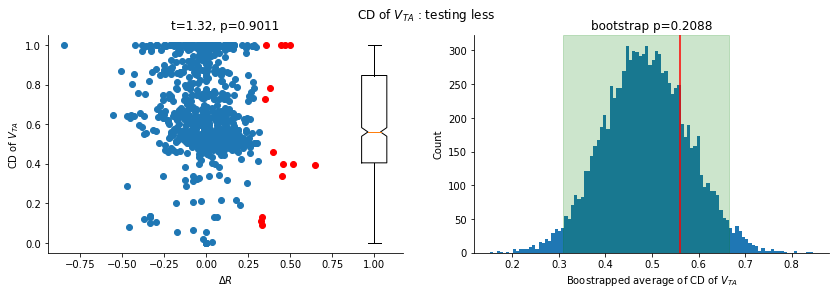

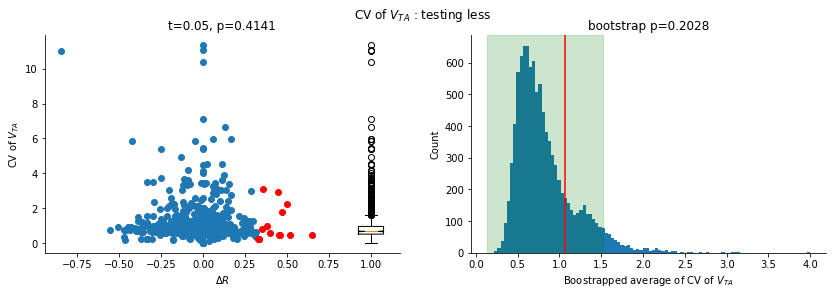

In [58]:
th_cd = stats.median_abs_deviation(th, 1)/np.median(th, 1)
th_cd[np.isnan(th_cd)] = 0
test_extreme(th_cd, 'CD of $V_{TA}$', 'less')
th_cv = th.std(1) / th.mean(1)
th_cv[np.isnan(th_cv)] = 0
test_extreme(th_cv, 'CV of $V_{TA}$', 'less')

In [59]:
# Constructs paths: [path: A list starting with the end node and tracing recursively the most reliable input synapse, until encountering B or a loop]
Bidx = netf['stimulated_neurons'][cfg.stimuli[Bstim]]
b = Bidx[Bidx < cfg.params['N_exc']]
paths = []
source = np.empty(cfg.params['N'])
for i in range(cfg.params['N']):
    path = []
    path.append(i)
    while True:
        pre = np.nanargmax(reliability[:, path[-1]])
        if pre < i:
            path.extend(paths[pre])
            break
        if pre in path:
            path.append(path.index(pre) - len(path))
            break
        path.append(pre)
        if pre in b:
            break
    paths.append(path)

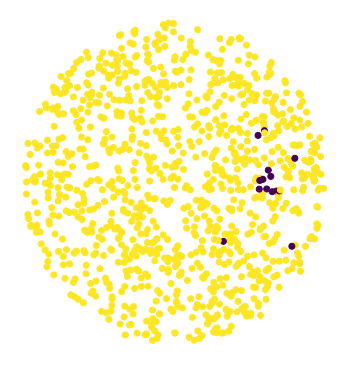

In [60]:
fig, ax = plt.subplots(figsize=(6,6.5))
scatter_values(ax, c=[np.any(np.isin(gatekeepers, path)) for path in paths])

In [61]:
# Constructs dependents: [i: The set of all neurons whose path includes target i]
dependents = []
for i in range(cfg.params['N']):
    deps = set()
    for path in paths:
        if i in path:
            deps.add(path[0])
    dependents.append(deps)

### GK are highly relied upon

{'pvalue': 0.0}

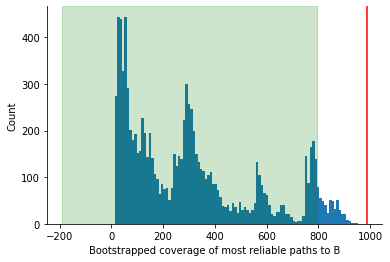

In [62]:
def coverage(idx):
    return len(dependents[idx[0]].union(*[dependents[i] for i in idx[1:]]))
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=coverage, alternative='less')
plt.hist(means, 100)
plt.axvline(coverage(gatekeepers), c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped coverage of most reliable paths to B')
sns.despine()
{'pvalue': p}

### No difference in correlation between sample and population responses
... but good correlation, anyway

({'bootstrap pvalue': 0.432},
 SpearmanrResult(correlation=0.837841576301006, pvalue=1.130768548025124e-106))

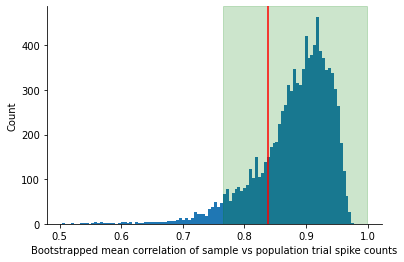

In [63]:
Xtrial = Xstd.sum(2)
nx = Xtrial.sum(0)
def corr(idx):
    return stats.spearmanr(Xtrial[idx].sum(0), nx).correlation
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=corr)
plt.hist(means, 100)
plt.axvline(corr(gatekeepers), c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped mean correlation of sample vs population trial spike counts')
sns.despine()
{'bootstrap pvalue': p}, stats.spearmanr(Xtrial[gatekeepers].sum(0), nx)

### No difference in effect on population spike count (linreg slope)

({'bootstrap pvalue': 0.7104},
 LinregressResult(slope=86.99120842729427, intercept=-231.34437733587842, rvalue=0.6870899470275592, pvalue=3.568612031679585e-57, stderr=4.6110423426165905, intercept_stderr=24.75189318924696))

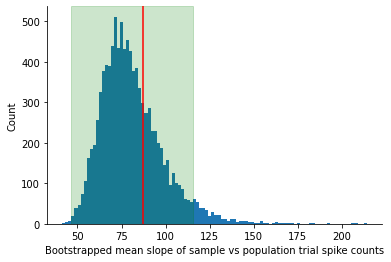

In [64]:
Xtrial = Xstd.sum(2)
nx = Xtrial.sum(0)
def slope(idx):
    return stats.linregress(Xtrial[idx].sum(0), nx).slope
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=slope)
plt.hist(means, 100)
plt.axvline(slope(gatekeepers), c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped mean slope of sample vs population trial spike counts')
sns.despine()
{'bootstrap pvalue': p}, stats.linregress(Xtrial[gatekeepers].sum(0), nx)

### Less effect on population (, subtree) spike count (Cohen's d)

{'bootstrap pvalue': 0.9646, 'd': 1.2920295094909156}

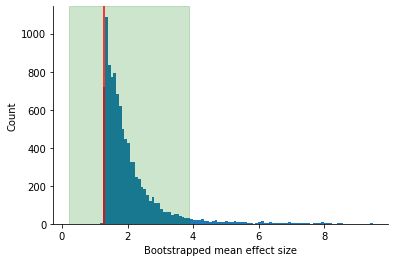

In [65]:
def effect_size(idx):
    s = Xtrial[idx].sum(0)
    mask = s > np.median(s)
    # Cohen's d:
    return (nx[mask].mean() - nx[~mask].mean())/np.sqrt((np.var(nx[mask])*mask.sum() + np.var(nx[~mask])*(~mask).sum())/mask.size-2)
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=effect_size, alternative='less')
plt.hist(means, 100)
plt.axvline(effect_size(gatekeepers), c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped mean effect size')
sns.despine()
{'bootstrap pvalue': p, 'd': effect_size(gatekeepers)}

WARNING    /tmp/ipykernel_64411/1550954197.py:6: RuntimeWarning: invalid value encountered in sqrt
  return (x[mask].mean() - x[~mask].mean())/np.sqrt((np.var(x[mask])*mask.sum() + np.var(x[~mask])*(~mask).sum())/mask.size-2)
 [py.warnings]


{'bootstrap pvalue': 0.9324, 'd': 1.289517813814773}

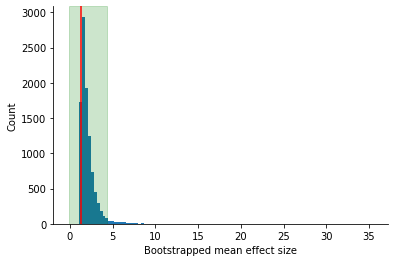

In [66]:
def effect_size_subtrees(idx):
    x = Xtrial[list(dependents[idx[0]].union(*[dependents[i] for i in idx[1:]]))].sum(0)
    s = Xtrial[idx].sum(0)
    mask = s > np.median(s)
    # Cohen's d:
    return (x[mask].mean() - x[~mask].mean())/np.sqrt((np.var(x[mask])*mask.sum() + np.var(x[~mask])*(~mask).sum())/mask.size-2)
means, p, ci = bootstrap_sameD(np.arange(cfg.params['N']), stat=effect_size_subtrees, alternative='less')
plt.hist(means, 100)
plt.axvline(effect_size_subtrees(gatekeepers), c='r')
plt.axvspan(*ci, color='g', alpha=.2)
plt.ylabel('Count')
plt.xlabel('Bootstrapped mean effect size')
sns.despine()
{'bootstrap pvalue': p, 'd': effect_size_subtrees(gatekeepers)}

### No difference in correlation with dependents' responses
... among neurons with dependents. Among all excitatory neurons, including those without dependents, GK correlate somewhat better.

WARNING    /home/felix/projects/culture/.env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
 [py.warnings]


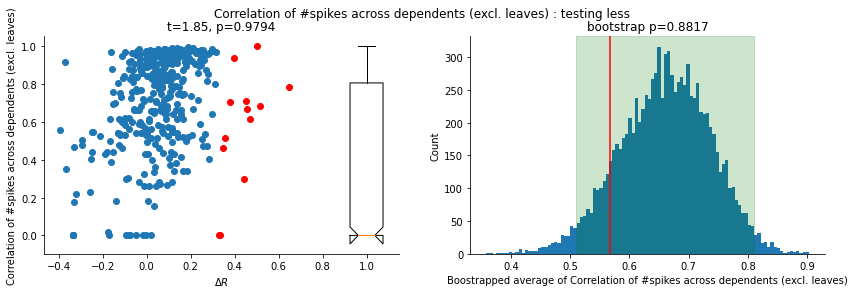

In [67]:
subtree_size = np.asarray([len(dep) for dep in dependents[:cfg.params['N_exc']]])
subtree_correlations = np.asarray([stats.spearmanr(Xtrial[[j for j in dependents[i] if i!=j]].sum(0), Xtrial[i]).correlation for i in range(cfg.params['N_exc'])])
subtree_correlations[np.isnan(subtree_correlations)] = 0
mask = subtree_size > 1
gatekeepers_bk = gatekeepers.copy()
gatekeepers = gatekeepers[mask[gatekeepers]]
others_bk = others.copy()
others = others[mask[others]]
Dtmp = D.copy()
Dtmp[:cfg.params['N_exc']][~mask] = -1
Dtmp[cfg.params['N_exc']:] = -1
test_extreme(subtree_correlations, 'Correlation of #spikes across dependents (excl. leaves)', 'less', D=Dtmp)
gatekeepers = gatekeepers_bk.copy()
others = others_bk.copy()

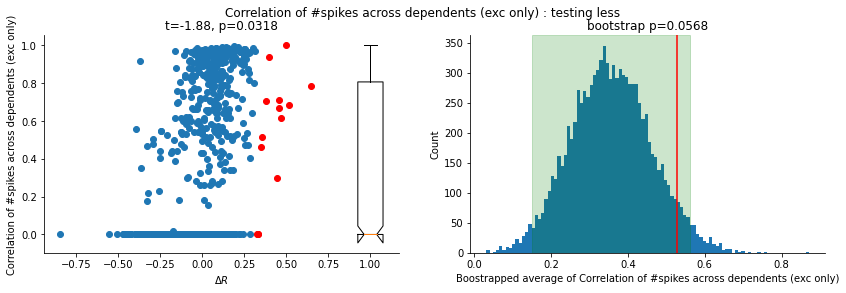

In [68]:
test_extreme(subtree_correlations, 'Correlation of #spikes across dependents (exc only)', 'less', D=D[:cfg.params['N_exc']])

### Lower (!) effect on dependents' spike counts

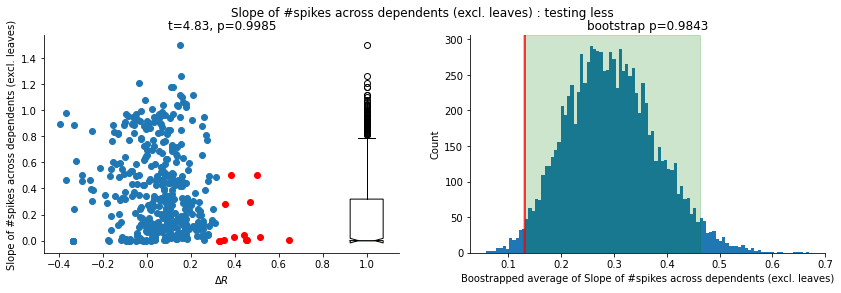

In [69]:
subtree_slopes = np.zeros(cfg.params['N_exc'])
for i in range(cfg.params['N_exc']):
    try:
        subtree_slopes[i] = stats.linregress(Xtrial[[j for j in dependents[i] if i!=j]].sum(0), Xtrial[i]).slope
    except ValueError:
        pass
subtree_slopes[np.isnan(subtree_slopes)] = 0
mask = subtree_size > 1
gatekeepers_bk = gatekeepers.copy()
gatekeepers = gatekeepers[mask[gatekeepers]]
others_bk = others.copy()
others = others[mask[others]]
Dtmp = D.copy()
Dtmp[:cfg.params['N_exc']][~mask] = -1
Dtmp[cfg.params['N_exc']:] = -1
test_extreme(subtree_slopes, 'Slope of #spikes across dependents (excl. leaves)', 'less', D=Dtmp)
gatekeepers = gatekeepers_bk.copy()
others = others_bk.copy()

## MSC

In [70]:
def get_reliability(X):
    Xe = X[:cfg.params['N_exc']]
    evoked = np.zeros((800, 1000))
    for pre, trial, t in zip(*np.nonzero(Xe)):
        tmax = min(t+latency, X.shape[-1]-1)
        for post in np.flatnonzero(We[pre]):
            evoked[pre, post] += np.sum(X[post, trial, t+1:tmax+1])>0
    reliability = 2 * evoked / (Xe.sum((1,2))[:, None] + X.sum((1,2))[None, :])
    reliability[np.isnan(W[:cfg.params['N_exc']])] = np.nan
    return reliability

In [71]:
reliability_msc = get_reliability(Xmsc)

WARNING    /tmp/ipykernel_64411/1330662381.py:8: RuntimeWarning: invalid value encountered in true_divide
  reliability = 2 * evoked / (Xe.sum((1,2))[:, None] + X.sum((1,2))[None, :])
 [py.warnings]


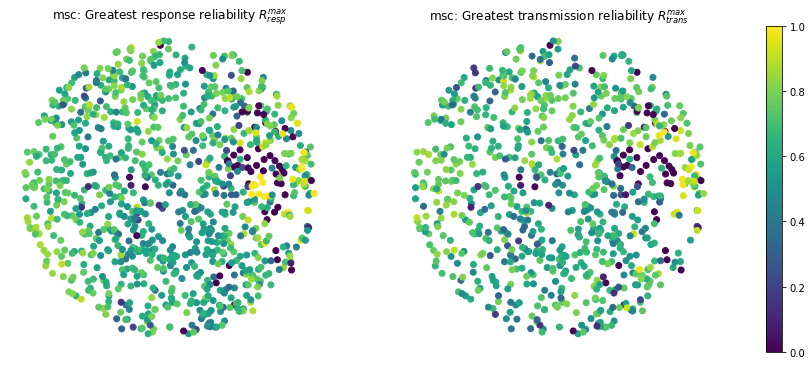

In [72]:
fig, axs = plt.subplots(1,2,figsize=(16,6))
rel_response_msc = np.nanmax(reliability_msc, 0)
rel_response_msc[netf['stimulated_neurons'][cfg.stimuli[Bstim]]] = 1
rel_transmit_msc = np.concatenate((np.nanmax(reliability_msc, 1), np.full(cfg.params['N_inh'], np.nan)))
m = scatter_values(axs[0], c=rel_response_msc, vmin=0, vmax=np.nanmax(reliability_msc))
axs[0].set_title('msc: Greatest response reliability $R_{resp}^{max}$')
scatter_values(axs[1], c=rel_transmit_msc, vmin=0, vmax=np.nanmax(reliability_msc))
axs[1].set_title('msc: Greatest transmission reliability $R_{trans}^{max}$')
plt.colorbar(m, ax=axs);

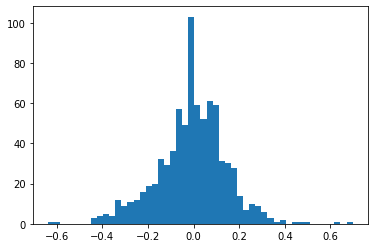

In [113]:
diff_rel_msc = get_delta_R(reliability_msc)
plt.hist(diff_rel_msc, bins=50);

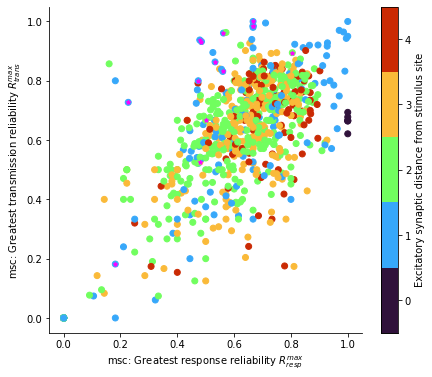

In [115]:
plt.figure(figsize=(7,6))
m = plt.scatter(rel_response_msc, rel_transmit_msc, c=D, cmap='turbo', vmax=D.max()+.5)
plt.scatter(rel_response_msc[gatekeepers], rel_transmit_msc[gatekeepers], c='magenta', s=20, marker='*')
plt.xlabel('msc: Greatest response reliability $R_{resp}^{max}$')
plt.ylabel('msc: Greatest transmission reliability $R_{trans}^{max}$')
plt.colorbar(m, values=range(D.max()+1), label='Excitatory synaptic distance from stimulus site')
sns.despine()

Text(0.5, 1.0, 'msc: Gatekeepers')

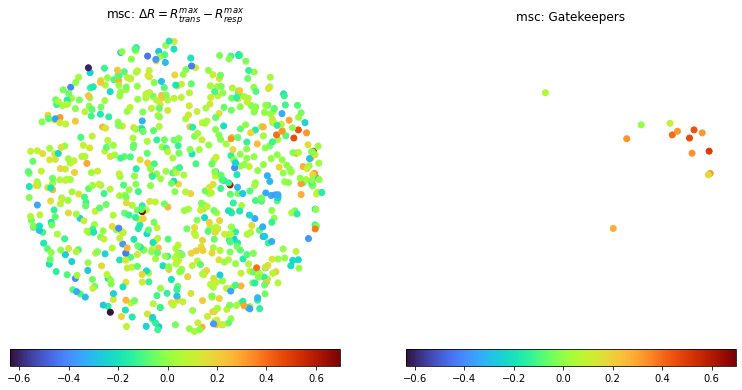

In [116]:
fig, axs = plt.subplots(1,2,figsize=(13,7))
m = scatter_values(axs[0], c=diff_rel_msc, cmap='turbo')
plt.colorbar(m, ax=axs[0], orientation='horizontal', pad=0)
axs[0].set_title('msc: $\\Delta R = R_{trans}^{max} - R_{resp}^{max}$')
c = np.full_like(diff_rel_msc, np.nan)
c[gatekeepers] = diff_rel_msc[gatekeepers]
m = scatter_values(axs[1], c=c, cmap='turbo', vmin=np.nanmin(diff_rel_msc), vmax=np.nanmax(diff_rel_msc))
plt.colorbar(m, ax=axs[1], orientation='horizontal', pad=0)
axs[1].set_title('msc: Gatekeepers')

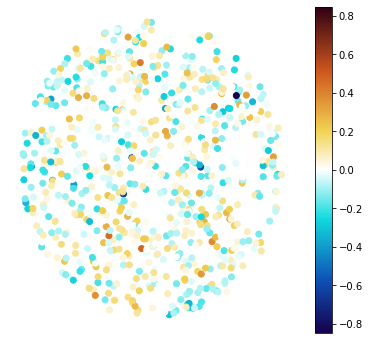

In [117]:
fig, ax = plt.subplots(figsize=(6.5, 6))
ddR = diff_rel - diff_rel_msc
ddRmax = np.nanmax(np.abs(ddR))
m = scatter_values(ax, c=ddR, cmap=pu.ccc_divergent, vmin=-ddRmax, vmax=ddRmax)
plt.colorbar(m)

### msc GK $\Delta R$ is higher

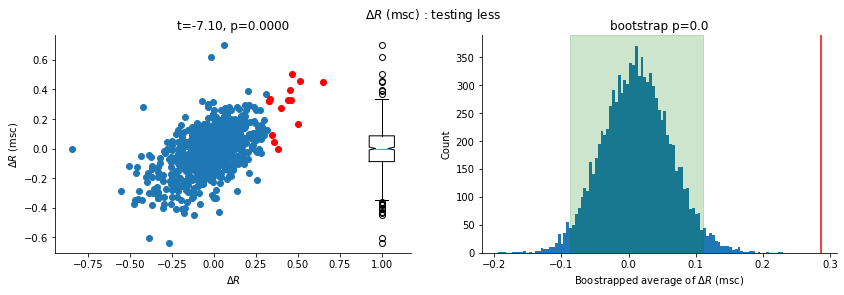

In [125]:
test_extreme(diff_rel_msc, '$\\Delta R$ (msc)', 'less')

### msc: GK response reliability is slightly lower

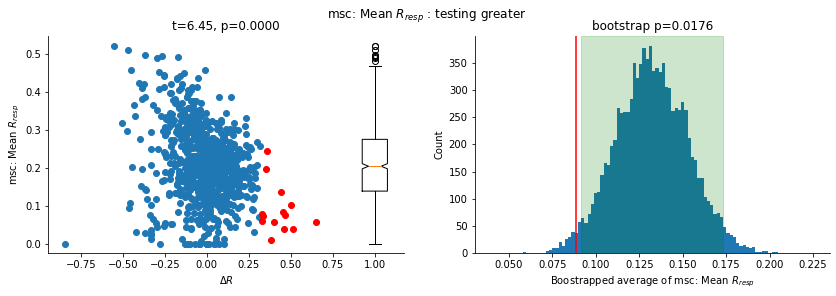

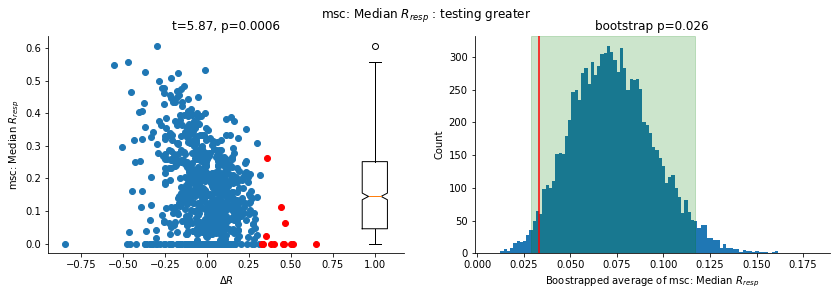

In [118]:
test_extreme(np.nanmean(reliability_msc, 0), 'msc: Mean $R_{resp}$', 'greater')
test_extreme(np.nanmedian(reliability_msc, 0), 'msc: Median $R_{resp}$', 'greater')

### msc: GK transmission reliability is very slightly lower

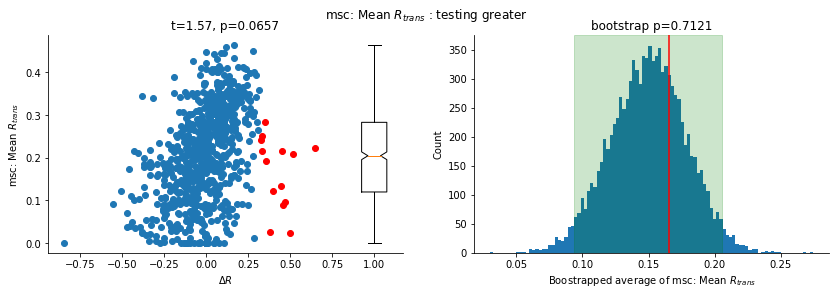

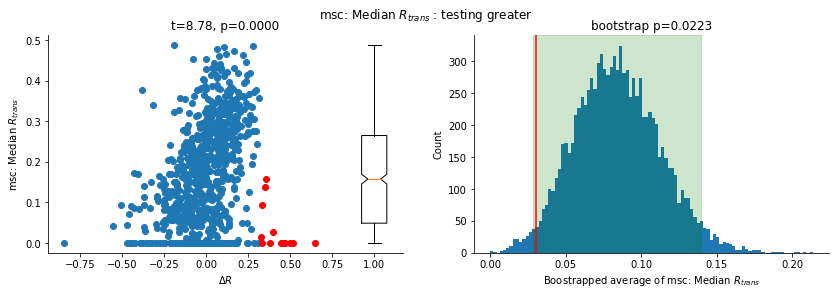

In [119]:
test_extreme(np.nanmean(reliability_msc, 1), 'msc: Mean $R_{trans}$', 'greater')
test_extreme(np.nanmedian(reliability_msc, 1), 'msc: Median $R_{trans}$', 'greater')

### msc: GK input (total spikes/trial) is less variable

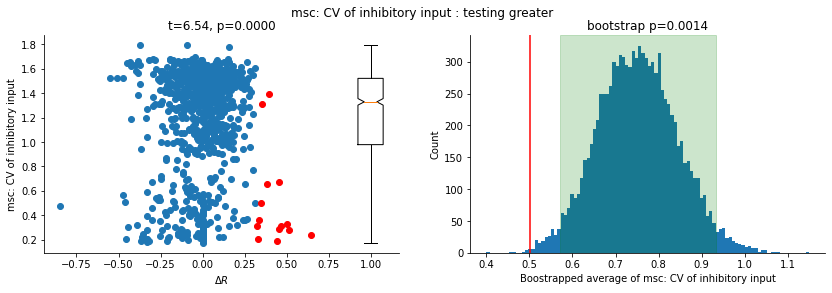

In [120]:
wi = Wb.copy()
wi[:cfg.params['N_exc']] = 0
inh_inputs = np.einsum('eo,et->ot', wi, Xmsc.sum(2))
test_extreme(inh_inputs.std(1) / inh_inputs.mean(1), 'msc: CV of inhibitory input', alternative='greater')

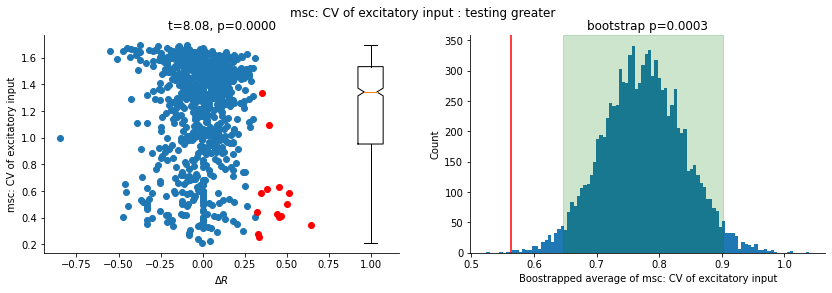

In [121]:
we = Wb.copy()
we[cfg.params['N_exc']:] = 0
exc_inputs = np.einsum('eo,et->ot', we, Xmsc.sum(2))
test_extreme(exc_inputs.std(1) / exc_inputs.mean(1), 'msc: CV of excitatory input', alternative='greater')

### msc: No difference in GK output

WARNING    /tmp/ipykernel_64411/2271316904.py:1: RuntimeWarning: invalid value encountered in true_divide
  act_cv = Xmsc.sum(2).std(1) / Xmsc.sum(2).mean(1)
 [py.warnings]


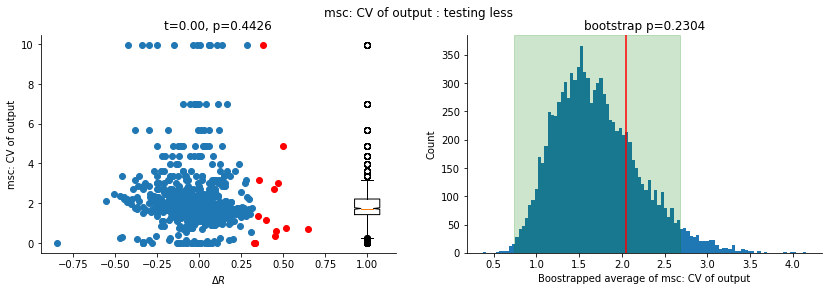

In [122]:
act_cv = Xmsc.sum(2).std(1) / Xmsc.sum(2).mean(1)
act_cv[np.isnan(act_cv)] = 0
test_extreme(act_cv, 'msc: CV of output', 'less')

### GK $\Delta V_{TA}$ (Adev,t=0 - Amsc,t=0) is higher

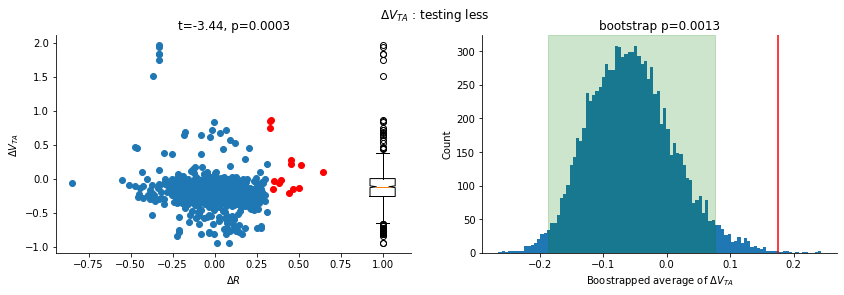

In [123]:
dTA = (
    res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev'], 0].mean(1)
    - res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc'], 0].mean(1))*volt/mV
test_extreme(dTA, '$\\Delta V_{TA}$', 'less')

# Brass tacks

Text(0.5, 1.0, 'Response to A: Adev - Amsc')

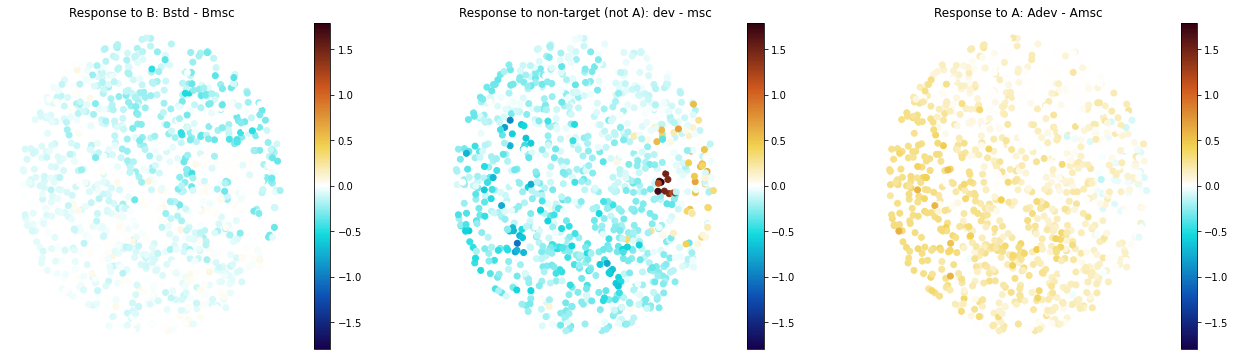

In [213]:
fig, axs = plt.subplots(1,3, figsize=(22,6))
diff_XB = Xstd.sum(2).mean(1) - Xmsc.sum(2).mean(1)
diff_X_notA = Xstd.sum(2).mean(1) - bspikes['msc'][:, sequences['msc']!=cfg.stimuli[stim]].sum(2).mean(1)
diff_XA = bspikes['dev'][:, sequences['dev']==cfg.stimuli[stim]].sum(2).mean(1) - bspikes['msc'][:, sequences['msc']==cfg.stimuli[stim]].sum(2).mean(1)
maxval = max(*[np.abs(val).max() for val in (diff_XB, diff_X_notA, diff_XA)])

m = scatter_values(axs[0], c=diff_XB, cmap=pu.ccc_divergent, vmin=-maxval, vmax=maxval)
plt.colorbar(m, ax=axs[0])
axs[0].set_title('Response to B: Bstd - Bmsc')

m = scatter_values(axs[1], c=diff_X_notA, cmap=pu.ccc_divergent, vmin=-maxval, vmax=maxval)
plt.colorbar(m, ax=axs[1])
axs[1].set_title('Response to non-target (not A): dev - msc')

m = scatter_values(axs[2], c=diff_XA, cmap=pu.ccc_divergent, vmin=-maxval, vmax=maxval)
plt.colorbar(m, ax=axs[2])
axs[2].set_title('Response to A: Adev - Amsc')

292 neurons respond more to B than to C/D/E


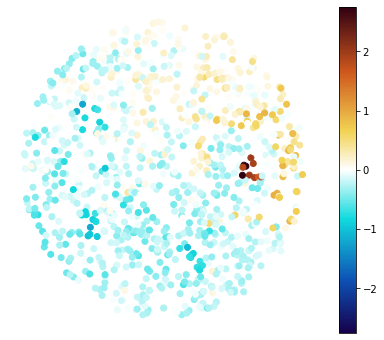

In [225]:
fig, ax = plt.subplots(figsize=(7,6))
greater_msc_B = bspikes['msc'][:, sequences['msc']==cfg.stimuli[Bstim]].sum(2).mean(1) \
    - bspikes['msc'][:, (sequences['msc']!=cfg.stimuli[Bstim]) & (sequences['msc']!=cfg.stimuli[stim])].sum(2).mean(1)
m = scatter_values(ax, c=greater_msc_B, vmin=-np.abs(greater_msc_B).max(), vmax=np.abs(greater_msc_B).max(), cmap=pu.ccc_divergent)
plt.colorbar(m)
print(np.sum(greater_msc_B>0), 'neurons respond more to B than to C/D/E')

The neurons labelled blue above respond more strongly to C/D/E than to B in the control condition. In the oddball condition, we replace stimulation of C/D/E with stimulation of B; even if the response to B did not change at all from adaptation, these neurons would respond less in non-target trials simply due to their stimulus selectivity.

907 neurons respond to A


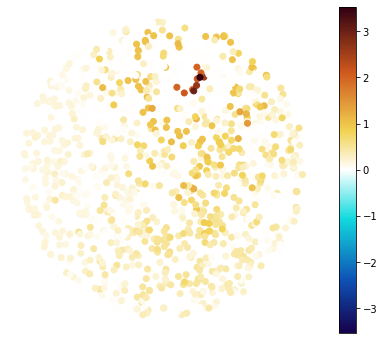

In [226]:
fig, ax = plt.subplots(figsize=(7,6))
msc_A = bspikes['msc'][:, sequences['msc']==cfg.stimuli[stim]].sum(2).mean(1)
m = scatter_values(ax, c=msc_A, vmin=-np.abs(msc_A).max(), vmax=np.abs(msc_A).max(), cmap=pu.ccc_divergent)
plt.colorbar(m)
print(np.sum(msc_A>0), 'neurons respond to A')

654 A-responding neurons are freed up by changing condition from control to oddball with a mean response difference of 0.2709225280326198


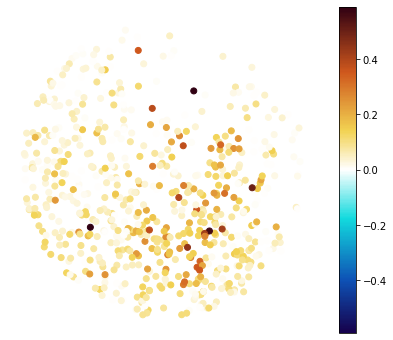

In [238]:
fig, ax = plt.subplots(figsize=(7,6))
freed_by_stimchange = (msc_A>0) & (greater_msc_B<0)
val = -msc_A * greater_msc_B
val[~freed_by_stimchange] = np.nan
m = scatter_values(ax, c=val, vmin=-np.nanmax(np.abs(val)), vmax=np.nanmax(np.abs(val)), cmap=pu.ccc_divergent)
plt.colorbar(m)
print(freed_by_stimchange.sum(), 'A-responding neurons are freed up by changing condition from control to oddball with a mean response difference of',
    -greater_msc_B[freed_by_stimchange].mean())

128 neurons respond more to B in oddball than in control


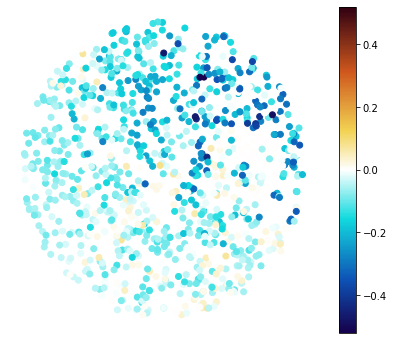

In [234]:
fig, ax = plt.subplots(figsize=(7,6))
diff_XB = Xstd.sum(2).mean(1) - Xmsc.sum(2).mean(1)
m = scatter_values(ax, c=diff_XB, vmin=-np.abs(diff_XB).max(), vmax=np.abs(diff_XB).max(), cmap=pu.ccc_divergent)
plt.colorbar(m)
print(np.sum(diff_XB>0), 'neurons respond more to B in oddball than in control')

740 A-responding neurons are freed up by adaptation to B with a mean response difference of 0.11944932432432434


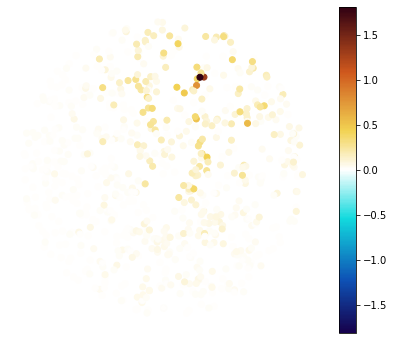

In [237]:
fig, ax = plt.subplots(figsize=(7,6))
freed_by_adaptation = (msc_A>0) & (diff_XB<0)
val = -msc_A * diff_XB
val[~freed_by_adaptation] = np.nan
m = scatter_values(ax, c=val, vmin=-np.nanmax(np.abs(val)), vmax=np.nanmax(np.abs(val)), cmap=pu.ccc_divergent)
plt.colorbar(m)
print(freed_by_adaptation.sum(), 'A-responding neurons are freed up by adaptation to B with a mean response difference of',
    -diff_XB[freed_by_adaptation].mean())

### Delta A

In [327]:
ms = 20

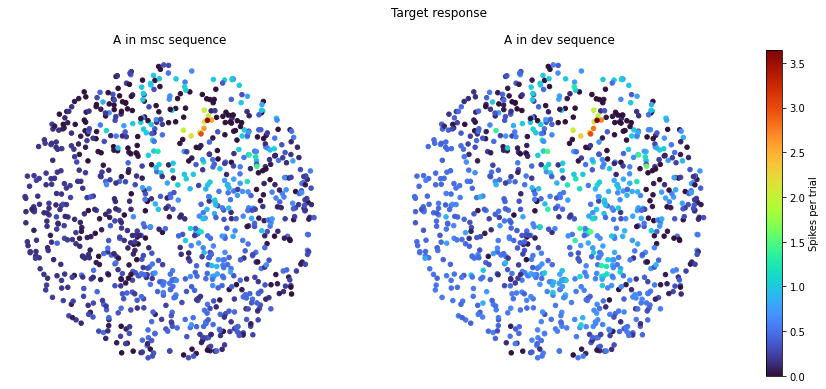

In [328]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
XA_dev = bspikes['dev'][:, sequences['dev']==cfg.stimuli[stim]].sum(2).mean(1)
XA_msc = bspikes['msc'][:, sequences['msc']==cfg.stimuli[stim]].sum(2).mean(1)
vmax = max(*[val.max() for val in (XA_dev, XA_msc)])
vmin = min(*[val.min() for val in (XA_dev, XA_msc)])

fig.suptitle('Target response')
scatter_values(axs[0], c=XA_msc, s=ms, vmin=vmin, vmax=vmax, cmap='turbo')
axs[0].set_title('A in msc sequence')
m = scatter_values(axs[1], c=XA_dev, s=ms, vmin=vmin, vmax=vmax, cmap='turbo')
axs[1].set_title('A in dev sequence')
plt.colorbar(m, ax=axs, label='Spikes per trial')

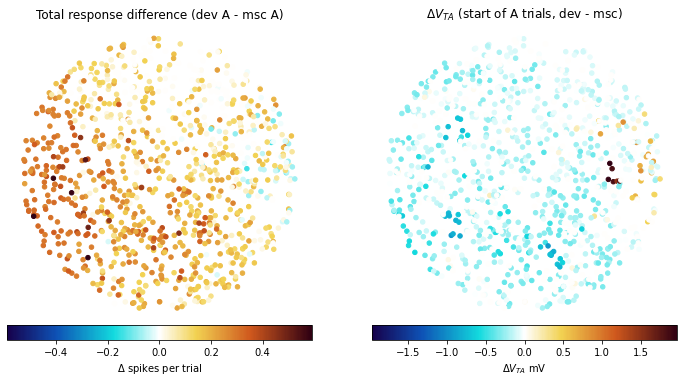

In [329]:
fig, axs = plt.subplots(1, 2, figsize=(12,6.5))
diff_XA = XA_dev - XA_msc
dTA = (
    res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev'], 0].mean(1)
    - res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc'], 0].mean(1))*volt/mV

vmax = np.abs(diff_XA).max()
m = scatter_values(axs[0], c=diff_XA, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('Total response difference (dev A - msc A)')
plt.colorbar(m, ax=axs[0], orientation='horizontal', pad=0, label='$\\Delta$ spikes per trial')

vmax = np.abs(dTA).max()
m = scatter_values(axs[1], c=dTA, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('$\\Delta V_{TA}$ (start of A trials, dev - msc)')
plt.colorbar(m, ax=axs[1], orientation='horizontal', pad=0, label='$\\Delta V_{TA}$ mV')

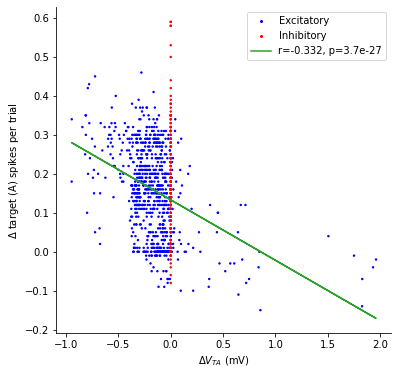

In [338]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(dTA, diff_XA, s=2, c=np.arange(cfg.params['N']) > cfg.params['N_exc'], cmap='bwr')
ax.set_xlabel('$\\Delta V_{TA}$ (mV)')
ax.set_ylabel('$\\Delta$ target (A) spikes per trial')
ax.plot([], 'bo', ms=2, label='Excitatory')
ax.plot([], 'ro', ms=2, label='Inhibitory')
regression = stats.linregress(dTA, diff_XA)
ax.plot(dTA, regression.intercept + regression.slope*dTA, 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
ax.legend()
sns.despine()

### Delta B

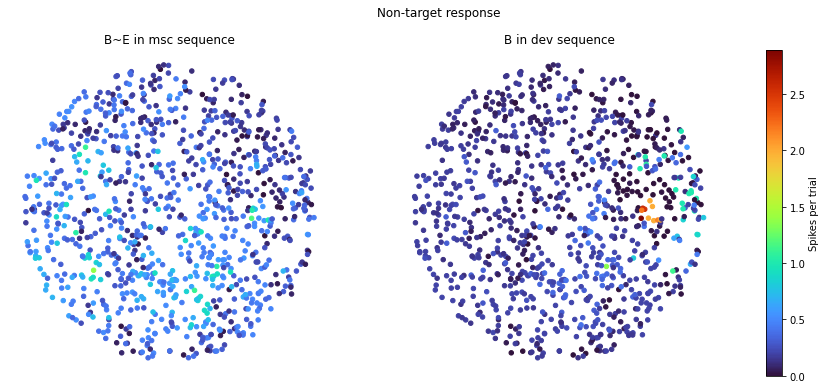

In [331]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
notA_dev = Xstd.sum(2).mean(1)
notA_msc = bspikes['msc'][:, sequences['msc']!=cfg.stimuli[stim]].sum(2).mean(1)
vmax = max(*[val.max() for val in (notA_dev, notA_msc)])
vmin = min(*[val.min() for val in (notA_dev, notA_msc)])

fig.suptitle('Non-target response')
scatter_values(axs[0], c=notA_msc, s=ms, vmin=vmin, vmax=vmax, cmap='turbo')
axs[0].set_title('B~E in msc sequence')
m = scatter_values(axs[1], c=notA_dev, s=ms, vmin=vmin, vmax=vmax, cmap='turbo')
axs[1].set_title('B in dev sequence')
plt.colorbar(m, ax=axs, label='Spikes per trial')

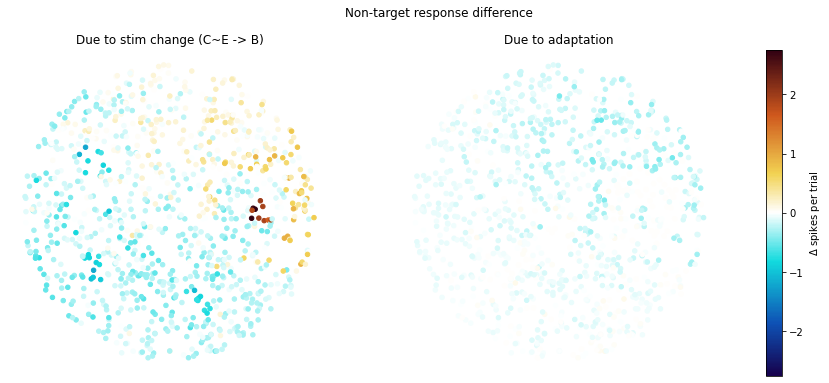

In [332]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))
greater_msc_B = bspikes['msc'][:, sequences['msc']==cfg.stimuli[Bstim]].sum(2).mean(1) \
    - bspikes['msc'][:, (sequences['msc']!=cfg.stimuli[Bstim]) & (sequences['msc']!=cfg.stimuli[stim])].sum(2).mean(1)
diff_XB = Xstd.sum(2).mean(1) - Xmsc.sum(2).mean(1)
vmax = max(*[np.abs(val).max() for val in (greater_msc_B, diff_XB)])

fig.suptitle('Non-target response difference')
scatter_values(axs[0], c=greater_msc_B, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[0].set_title('Due to stim change (C~E -> B)')
m = scatter_values(axs[1], c=diff_XB, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[1].set_title('Due to adaptation')
plt.colorbar(m, ax=axs, label='$\\Delta$ spikes per trial')

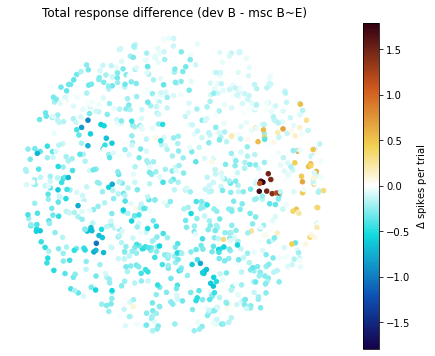

In [333]:
fig, ax = plt.subplots(figsize=(7.5,6))
diff_X_notA = Xstd.sum(2).mean(1) - bspikes['msc'][:, sequences['msc']!=cfg.stimuli[stim]].sum(2).mean(1)
vmax = np.abs(diff_X_notA).max()
m = scatter_values(ax, c=diff_X_notA, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
ax.set_title('Total response difference (dev B - msc B~E)')
plt.colorbar(m, ax=ax, label='$\\Delta$ spikes per trial')

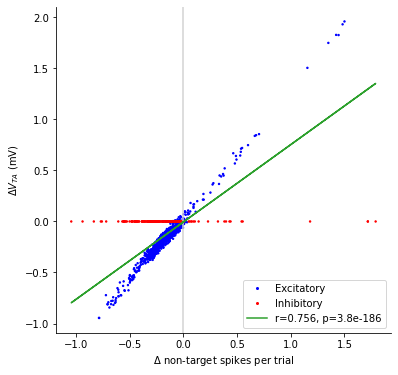

In [376]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(diff_X_notA, dTA, s=2, c=np.arange(cfg.params['N']) > cfg.params['N_exc'], cmap='bwr')
ax.axvline(0, color='lightgrey')
ax.set_xlabel('$\\Delta$ non-target spikes per trial')
ax.set_ylabel('$\\Delta V_{TA}$ (mV)')
ax.plot([], 'bo', ms=2, label='Excitatory')
ax.plot([], 'ro', ms=2, label='Inhibitory')
regression = stats.linregress(diff_X_notA, dTA)
ax.plot(diff_X_notA, regression.intercept + regression.slope*diff_X_notA, 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
ax.legend()
sns.despine()

### Response-weighted TA

In [377]:
TA_A_dev = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev'], 0].mean(1)*volt/mV
TA_A_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc'], 0].mean(1)*volt/mV
dTA_A = TA_A_dev - TA_A_msc
XA_dev = bspikes['dev'][:, trials['dev']].sum(2).mean(1)
XA_msc = bspikes['msc'][:, trials['msc']].sum(2).mean(1)
dXA = XA_dev - XA_msc
TA_B_dev = res['raw_dynamics']['th_adapt'][:, episodes['dev'], trials[f'dev-B'], 0].mean(1)*volt/mV
TA_B_msc = res['raw_dynamics']['th_adapt'][:, episodes['msc'], trials[f'msc-B'], 0].mean(1)*volt/mV
dTA_B = TA_B_dev - TA_B_msc
XB_dev = bspikes['dev'][:, trials['dev-B']].sum(2).mean(1)
XnotA_msc = bspikes['msc'][:, ~trials['msc']].sum(2).mean(1)
dXnotA = XB_dev - XnotA_msc
threshold = .2

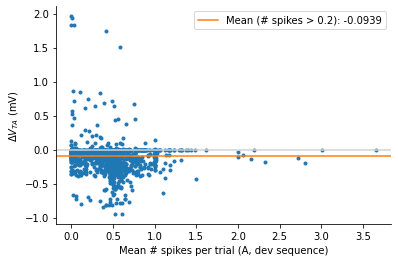

In [378]:
plt.plot(XA_dev, dTA_A, '.')
plt.axhline(0, color='lightgrey')
plt.xlabel('Mean # spikes per trial (A, dev sequence)')
plt.ylabel('$\\Delta V_{TA}$ (mV)')
m = np.mean((XA_dev * dTA_A)[XA_dev > threshold])
plt.axhline(m, color='C1')
plt.plot([], 'C1', label=f'Mean (# spikes > {threshold:.1f}): {m:.3g}')
plt.legend()
sns.despine()

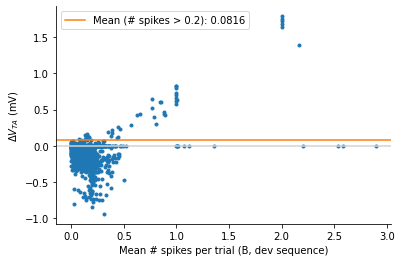

In [379]:
plt.plot(XB_dev, dTA_B, '.')
plt.axhline(0, color='lightgrey')
plt.xlabel('Mean # spikes per trial (B, dev sequence)')
plt.ylabel('$\\Delta V_{TA}$ (mV)')
m = np.mean((XB_dev * dTA_B)[XB_dev > threshold])
plt.axhline(m, color='C1')
plt.plot([], 'C1', label=f'Mean (# spikes > {threshold:.1f}): {m:.3g}')
plt.legend()
sns.despine()

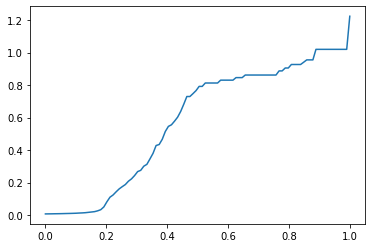

In [395]:
cutoff = np.linspace(0,1,100)
m = []
for c in cutoff:
    m.append(np.mean((XB_dev * dTA_B)[XB_dev > c]))
plt.plot(cutoff, m)

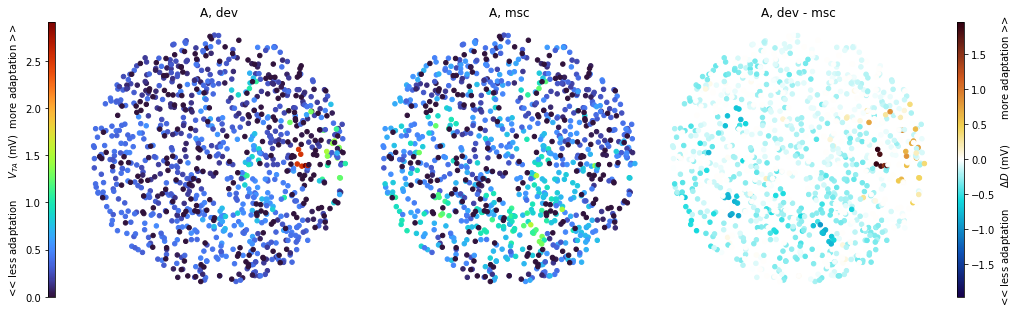

In [380]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs([TA_A_dev, TA_A_msc]).max()
m = scatter_values(axs[0], c=TA_A_dev, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0].set_title('A, dev')
m = scatter_values(axs[1], c=TA_A_msc, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1].set_title('A, msc')
plt.colorbar(m, ax=axs, label='<< less adaptation\t $V_{TA}$ (mV) \tmore adaptation >>', location='left', aspect=40, pad=0.02)

vmax = np.abs(dTA_A).max()
m = scatter_values(axs[2], c=dTA_A, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('A, dev - msc')
plt.colorbar(m, ax=axs, label='<< less adaptation\t $\\Delta D$ (mV) \tmore adaptation >>', aspect=40, pad=0.02)

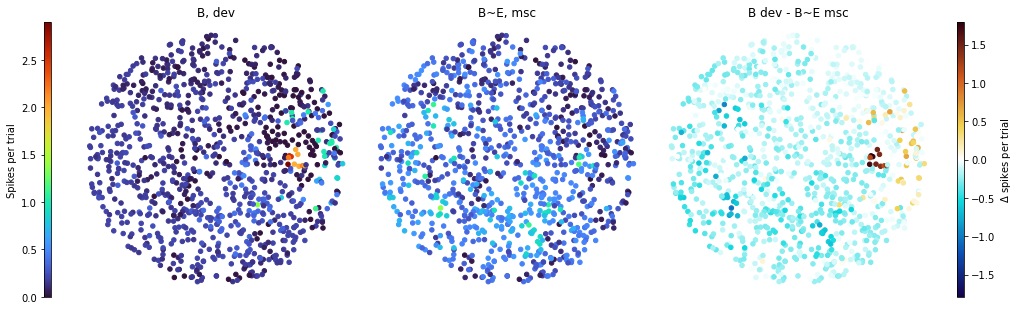

In [381]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4.2), constrained_layout=True)

vmax = np.abs([XB_dev, XnotA_msc]).max()
m = scatter_values(axs[0], c=XB_dev, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[0].set_title('B, dev')
m = scatter_values(axs[1], c=XnotA_msc, s=ms, vmin=0, vmax=vmax, cmap='turbo')
axs[1].set_title('B~E, msc')
plt.colorbar(m, ax=axs, label='Spikes per trial', location='left', aspect=40, pad=0.02)

vmax = np.abs(dXnotA).max()
m = scatter_values(axs[2], c=dXnotA, s=ms, vmin=-vmax, vmax=vmax, cmap=pu.ccc_divergent)
axs[2].set_title('B dev - B~E msc')
plt.colorbar(m, ax=axs, label='$\\Delta$ spikes per trial', aspect=40, pad=0.02)

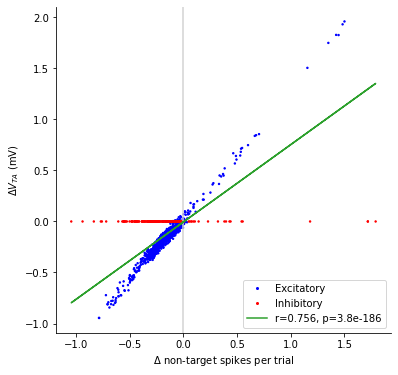

In [384]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(dXnotA, dTA_A, s=2, c=np.arange(cfg.params['N']) > cfg.params['N_exc'], cmap='bwr')
ax.axvline(0, color='lightgrey')
ax.set_xlabel('$\\Delta$ non-target spikes per trial')
ax.set_ylabel('$\\Delta V_{TA}$ (mV)')
ax.plot([], 'bo', ms=2, label='Excitatory')
ax.plot([], 'ro', ms=2, label='Inhibitory')
regression = stats.linregress(dXnotA, dTA_A)
ax.plot(dXnotA, regression.intercept + regression.slope*dXnotA, 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
ax.legend()
sns.despine()

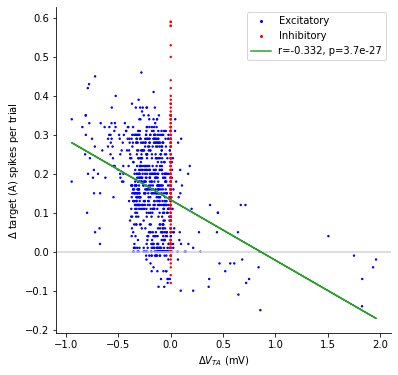

In [385]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(dTA_A, dXA, s=2, c=np.arange(cfg.params['N']) > cfg.params['N_exc'], cmap='bwr')
plt.axhline(0, color='lightgrey')
ax.set_xlabel('$\\Delta V_{TA}$ (mV)')
ax.set_ylabel('$\\Delta$ target (A) spikes per trial')
ax.plot([], 'bo', ms=2, label='Excitatory')
ax.plot([], 'ro', ms=2, label='Inhibitory')
regression = stats.linregress(dTA_A, dXA)
ax.plot(dTA_A, regression.intercept + regression.slope*dTA_A, 'C2', label=f'r={regression.rvalue:.3g}, p={regression.pvalue:.2g}')
ax.legend()
sns.despine()